# Language Influence Social Network Patterns: A Case Study

### Introduction

In this project, we would like to play with the language feature from the original dataset. There has always been a stereotype that western people are more active on social media than eastern people. To verify such trends, we propose to analyze the features’ distribution of different language users. We can decide a user's activeness from some features such as tweet counts, friend numbers etc. Moreover, we would like to learn if language clusters exist on Twitter. If so, we want to learn to what extent they are going to interact with different clusters. In order to do so, we would run the community algorithm provided by networkx modules and see if we can detect the clusters of different language groups. In the end, we could apply machine learning to see if we can predict the language of a user based on the features of his/her own Twitter profile and that of the follower-followee network.

### Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import networkx as nx
from networkx.algorithms import community
from datetime import datetime, timedelta

In [2]:
# MAYBE REMOVE THIS FROM HERE LATER
# Ignore SettingWithCopyWarning - Reference: https://www.dataquest.io/blog/settingwithcopywarning/
pd.set_option('mode.chained_assignment', None)

### Load Profiles Dataset

Profiles dataset contains ID, followers count, friends count, statuses count, and language.

In [3]:
# Load the user profiles as Dataframe
ego_alter_profiles = pd.read_csv("../Data/EgoAlterProfiles.txt", sep = '\t')

### Data Preprocessing

##### 1. Filter out languages used by small number of users

Some languages in the dataset are used by a very small number (less than 100, here) of users. Including such users might bias the results. Hence, these lanuages are not taken into account and filtered out. 

##### 2.  Add area column

One of our research questions concerns analysis between the eastern and western communities and their behaviours on Twitter. In order to do so, we need to classify the languages into east and west before the analysis.

In [4]:
# Filter egos with at least one follower and at least one friend
ego_alter_profiles = ego_alter_profiles[ ego_alter_profiles['IsEgo']==True ]
ego_alter_profiles = ego_alter_profiles[ ego_alter_profiles['followers_count']>0 ]
ego_alter_profiles = ego_alter_profiles[ ego_alter_profiles['friends_count']>0 ]
ego_alter_profiles['lang'] = ego_alter_profiles['lang'].str.lower()

# Create a new dataset focused on languages
languages_count = ego_alter_profiles.groupby('lang')['ID'].count().reset_index(name = 'count')
# Languages used by very less (<100) users might bias the results.
small_language = languages_count[languages_count['count'] < 100]['lang'].to_list()
# Hence, such users and languages are filtered out
languages_with_alter = ego_alter_profiles[ ~ego_alter_profiles['lang'].isin(small_language) ].reset_index(drop = True)
languages_with_alter = languages_with_alter[['ID','IsEgo', 'followers_count', 'friends_count', 'statuses_count', 'lang', 'created_at']]
languages_with_alter = languages_with_alter.dropna()

# Following list of languages are considered 'western' - NEEDS REFERENCE
western_language = ['bg', 'ca', 'cs', 'da', 'de', 'el', 'en', 'en-au', 'en-gb', 'es', 'es-mx', 'eu', 'fa',
                 'fi',  'fr', 'he', 'hi', 'hr', 'hu',   'it', 'ka', 'lv', 'nb', 'nl', 'no', 'pl', 'pt',
                 'pt-pt', 'ro', 'ru', 'sr', 'sv', 'uk']
# Following list of languages are considered 'eastern' - NEEDS REFERENCE
eastern_language = ['ar', 'az', 'fil', 'id', 'in', 'ja', 'ko', 'ms', 'msa', 'th', 'tr', 'vi' , 'zh', 'zh-cn',
                    'zh-hans', 'zh-hant', 'zh-tw']

# Following subset of languages are used by the egos in the dataset
western_language_ego = ['ru', 'fr', 'nl', 'de', 'pt', 'it', 'es', 'en-gb', 'en']
eastern_language_ego = ['ar', 'id', 'tr', 'ja', 'th', 'ko']

# Simple function to sort users based upon their language
# into western and eastern areas
def classify_lang(lang):
    if lang in western_language:
        return 'West'
    if lang in eastern_language:
        return 'East'

# Add a new column 'area' to classify users into western and eastern areas
languages_with_alter['area'] = languages_with_alter['lang'].apply(classify_lang)
languages = languages_with_alter[ languages_with_alter['IsEgo'] == True] 
languages.head()

ID  IsEgo  followers_count  friends_count  statuses_count lang  \
0   1   True             30.0             28             9.0   en   
1   2   True              2.0              8             7.0   en   
2   4   True              3.0              3            68.0   en   
3   5   True             65.0            118           748.0   fr   
4   7   True             17.0             71          1034.0   pt   

                       created_at  area  
0  Wed Oct 26 03:30:32 +0000 2011  West  
1  Mon Jul 27 20:46:32 +0000 2009  West  
2  Sun Feb 14 07:50:39 +0000 2010  West  
3  Mon Jun 11 14:17:06 +0000 2012  West  
4  Thu Nov 11 22:05:15 +0000 2010  West

### 3. Add internationality column

There are errors... TO FIX!!!

(I am not sure I understand what 'internationality' means here)

In [5]:
# Load the ego networks as DataFrame
ego_networks = pd.read_csv("Data/EgoNetworks.txt", sep = '\t')

# Load the user profiles as Dataframe with only the language information
newlanguages = pd.read_csv("Data/EgoAlterProfiles.txt", sep = '\t')[['ID','lang']]
newlanguages['lang'] = newlanguages['lang'].str.lower()

# Ignore SettingWithCopyWarning - Reference: https://www.dataquest.io/blog/settingwithcopywarning/
#pd.set_option('mode.chained_assignment', None)

# Create dictionary mapping between users and their languages 
user_lang = dict(zip(newlanguages['ID'], newlanguages['lang']))

# Function to return user language from ID
def get_lang(ID):
    return user_lang[ID]

# consider only the Ego (as followee)
ego_networks = ego_networks[ ego_networks['followeeID'].isin(languages['ID']) ]

# compute the followee language
ego_networks = pd.merge(ego_networks, languages[['ID','lang']], left_on='followeeID', right_on='ID')
print(ego_networks)
# computw the followers language
ego_networks['followers_lang'] = ego_networks['followerID'].apply(get_lang)

ego_networks = ego_networks.groupby(['egoID','lang','followers_lang']).size().to_frame('size')
ego_networks.reset_index(level=['egoID','lang','followers_lang'], inplace=True)
print(ego_networks)
print(ego_networks[ ego_networks['lang']==ego_networks['followers_lang'] ].groupby(['egoID'])['size'].sum())
print(ego_networks.groupby(['egoID'])['size'].sum())
languages['internationality'] = 0
users = ego_networks[ ego_networks['lang']==ego_networks['followers_lang'] ]['egoID']
print(users)
print(languages['ID'].isin(users))
languages['internationality'][ languages['ID'].isin(users-1) ] = 1 - (ego_networks[ ego_networks['lang']==ego_networks['followers_lang'] ].groupby(['egoID'])['size'].sum() / ego_networks.groupby(['egoID'])['size'].sum())
#print(ego_networks)
#languages = pd.merge(languages, ego_networks[['egoID', 'internationality']], left_on='ID', right_on='egoID')
languages

FileNotFoundError: [Errno 2] File Data/EgoNetworks.txt does not exist: 'Data/EgoNetworks.txt'

### 4. Add Daily Tweets

The average daily number of tweets are calculated for each user by dividing the total number of tweets by the number of active days for each user. The number of active days refer to the number of days starting from the creation of the user's Twitter account to the most recent record of a Tweet in the dataset. 

In [6]:
# Load the ego timelines as Dataframe
timelines = pd.read_csv("../Data/EgoTimelines.txt", sep = '\t', encoding = 'latin - 1')

In [7]:
# Convert the user subscription time to datetime object
def convert_time_format(twt_time: str):
    std_time = datetime.strptime(twt_time, '%a %b %d %H:%M:%S %z %Y')
    return std_time

# Add the standard datetime format to a new column - timelines df
timelines['std_time'] = timelines['created_at'].astype('str').apply(convert_time_format)

# Add the standard datetime format to a new column - languages df
languages['std_time'] = languages['created_at'].astype('str').apply(convert_time_format)

In [8]:
# Find the date for the most recent tweet
recent_date = timelines['std_time'].max()

# Find the number of days between the user subscription time and the most recent tweet available
languages['num_days'] = recent_date - languages['std_time']

In [9]:
# Get the number of days from the timedelta object
def get_days(time_obj):
    return time_obj.days

languages['num_days'] = languages['num_days'].apply(get_days)

In [10]:
languages

ID  IsEgo  followers_count  friends_count  statuses_count lang  \
0          1   True             30.0             28             9.0   en   
1          2   True              2.0              8             7.0   en   
2          4   True              3.0              3            68.0   en   
3          5   True             65.0            118           748.0   fr   
4          7   True             17.0             71          1034.0   pt   
...      ...    ...              ...            ...             ...  ...   
18532  33994   True              1.0             13             0.0   es   
18533  33997   True              1.0              6             0.0   en   
18534  33998   True              1.0             60             1.0   en   
18535  34003   True            194.0             95           370.0   es   
18536  34005   True              1.0             19             0.0   pt   

                           created_at  area                  std_time  \
0      Wed Oct 26 03:30:32 +0000 2011  West 2011-10-26 03:30:32+00:00   
1      Mon Jul 27 20:46:32 +0000 2009  West 2009-07-27 20:46:32+00:00   
2      Sun Feb 14 07:50:39 +0000 2010  West 2010-02-14 07:50:39+00:00   
3      Mon Jun 11 14:17:06 +0000 2012  West 2012-06-11 14:17:06+00:00   
4      Thu Nov 11 22:05:15 +0000 2010  West 2010-11-11 22:05:15+00:00   
...                               ...   ...                       ...   
18532  Wed May 14 20:37:28 +0000 2014  West 2014-05-14 20:37:28+00:00   
18533  Thu Dec 26 03:11:06 +0000 2013  West 2013-12-26 03:11:06+00:00   
18534  Sat Jun 14 07:57:12 +0000 2014  West 2014-06-14 07:57:12+00:00   
18535  Thu Apr 17 20:22:32 +0000 2014  West 2014-04-17 20:22:32+00:00   
18536  Sun Jan 12 01:24:51 +0000 2014  West 2014-01-12 01:24:51+00:00   

       num_days  
0          1101  
1          1921  
2          1719  
3           871  
4          1449  
...         ...  
18532       169  
18533       309  
18534       138  
18535       196  
18536       292  

[18537 rows x 10 columns]

In [11]:
# Find mean number of tweets per day 
languages['avg_daily_tweets'] = languages['statuses_count'] / languages['num_days']

# Dropping the irrelevant columns
languages = languages.drop(columns = ['created_at', 'std_time', 'num_days'])

In [12]:
languages

ID  IsEgo  followers_count  friends_count  statuses_count lang  \
0          1   True             30.0             28             9.0   en   
1          2   True              2.0              8             7.0   en   
2          4   True              3.0              3            68.0   en   
3          5   True             65.0            118           748.0   fr   
4          7   True             17.0             71          1034.0   pt   
...      ...    ...              ...            ...             ...  ...   
18532  33994   True              1.0             13             0.0   es   
18533  33997   True              1.0              6             0.0   en   
18534  33998   True              1.0             60             1.0   en   
18535  34003   True            194.0             95           370.0   es   
18536  34005   True              1.0             19             0.0   pt   

       area  avg_daily_tweets  
0      West          0.008174  
1      West          0.003644  
2      West          0.039558  
3      West          0.858783  
4      West          0.713596  
...     ...               ...  
18532  West          0.000000  
18533  West          0.000000  
18534  West          0.007246  
18535  West          1.887755  
18536  West          0.000000  

[18537 rows x 8 columns]

### Language Statistic

To get an overview of the dataset, we grouped the dataset by the language column and calculate the mean value of followers count, friends count, statuses count and average daily statuses count among different languages.

In [13]:
languages_stat = (languages.groupby('lang')[['followers_count', 'friends_count', 'statuses_count', 'avg_daily_tweets']]
.mean()
.reset_index())

languages_count_dict = dict(zip(languages_count['lang'], languages_count['count']))

def add_count(lang):
    return languages_count_dict[lang]

languages_stat['user_count'] = languages_stat['lang'].apply(add_count)
languages_stat['area'] = languages_stat['lang'].apply(classify_lang)
languages_stat.set_index('lang', inplace = True)
languages_stat.sort_values(by = 'user_count', inplace = True)

languages_stat.head()

followers_count  friends_count  statuses_count  avg_daily_tweets  \
lang                                                                      
en-gb       205.327586     133.301724      255.706897          0.718704   
nl           52.979021      74.384615     1220.048951          1.395792   
de           91.497175     135.847458      162.638418          0.180196   
ko           27.859459      58.664865      300.145946          0.679269   
it           33.385246      76.688525      267.725410          0.352877   

       user_count  area  
lang                     
en-gb         116  West  
nl            143  West  
de            177  West  
ko            185  East  
it            244  West

In [14]:
print("The maximum avg number of followers belong to <", languages_stat['followers_count'].idxmax(), "> language.")
print("The minimum avg number of followers belong to <", languages_stat['followers_count'].idxmin(), "> language.")

print("The maximum avg number of friends belong to <", languages_stat['friends_count'].idxmax(), "> language.")
print("The minimum avg number of friends belong to <", languages_stat['friends_count'].idxmin(), "> language.")

print("The maximum avg number of statuses belong to <", languages_stat['statuses_count'].idxmax(), "> language.")
print("The minimum avg number of statuses belong to <", languages_stat['statuses_count'].idxmin(), "> language.")

print("The maximum avg number of daily tweets belong to <", languages_stat['avg_daily_tweets'].idxmax(), "> language.")
print("The minimum avg number of daily tweets belong to <", languages_stat['avg_daily_tweets'].idxmin(), "> language.")

The maximum avg number of followers belong to < ar > language.
The minimum avg number of followers belong to < ko > language.
The maximum avg number of friends belong to < ar > language.
The minimum avg number of friends belong to < ko > language.
The maximum avg number of statuses belong to < ja > language.
The minimum avg number of statuses belong to < de > language.
The maximum avg number of daily tweets belong to < ja > language.
The minimum avg number of daily tweets belong to < de > language.


Conclusion, if any: 
1. The maximum followers and friends -> ar. They are quite popular online. 
2. The minimum followers and friends -> ko. They tend to have less online presence.
3. The maximum tweets and daily tweets -> ja. They spend a lot of time online. 
2. The minimum tweets and daily tweets -> de. They tend to be less active online. 

### Data Exploration

From the figures below, we can figure out the language composition of the dataset.

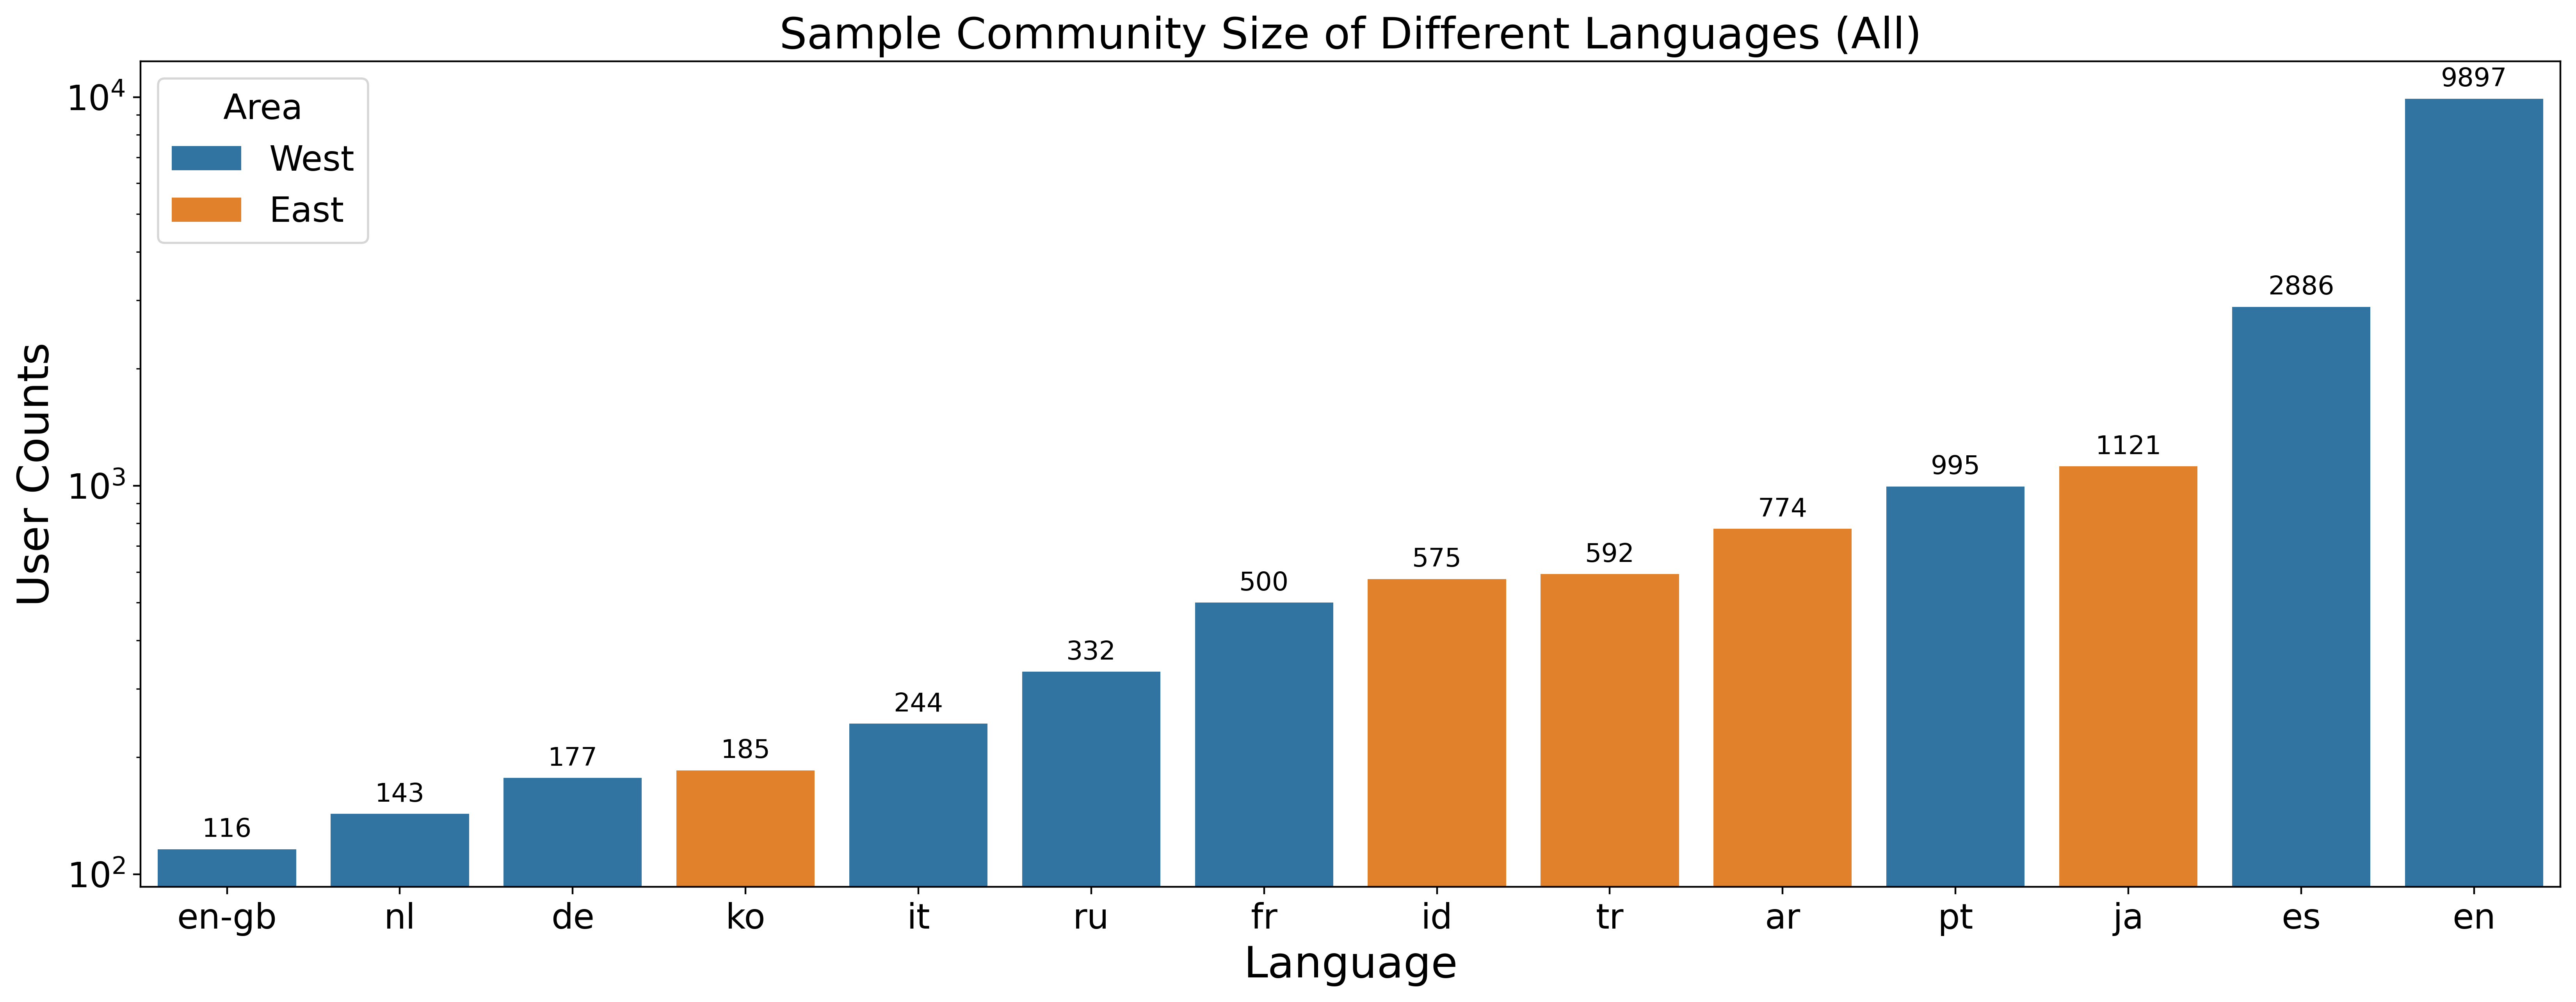

In [15]:
fig, ax = plt.subplots(figsize = (20, 7), dpi = 400)

ax.set(yscale = 'log')
splot = sns.barplot(x = languages_stat.index, y = languages_stat['user_count'], hue = languages_stat['area'], ax = ax,
           dodge = False)
ax.set_xlabel('Language', fontsize = 20)
ax.set_ylabel('User Counts', fontsize = 20)
ax.set_title('Sample Community Size of Different Languages (All)', fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.legend(title="Area", fontsize=16, title_fontsize=16)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize = 12) 
plt.show()

Conclusions, if any: 
1. Beware of log scale. Very high majority of < en > language users.
2. Top three western languages < en, es, pt > constitute ~75% of the total users. 
3. 9 western vs 5 eastern languages. 15,290 western vs 3,247 eastern users.

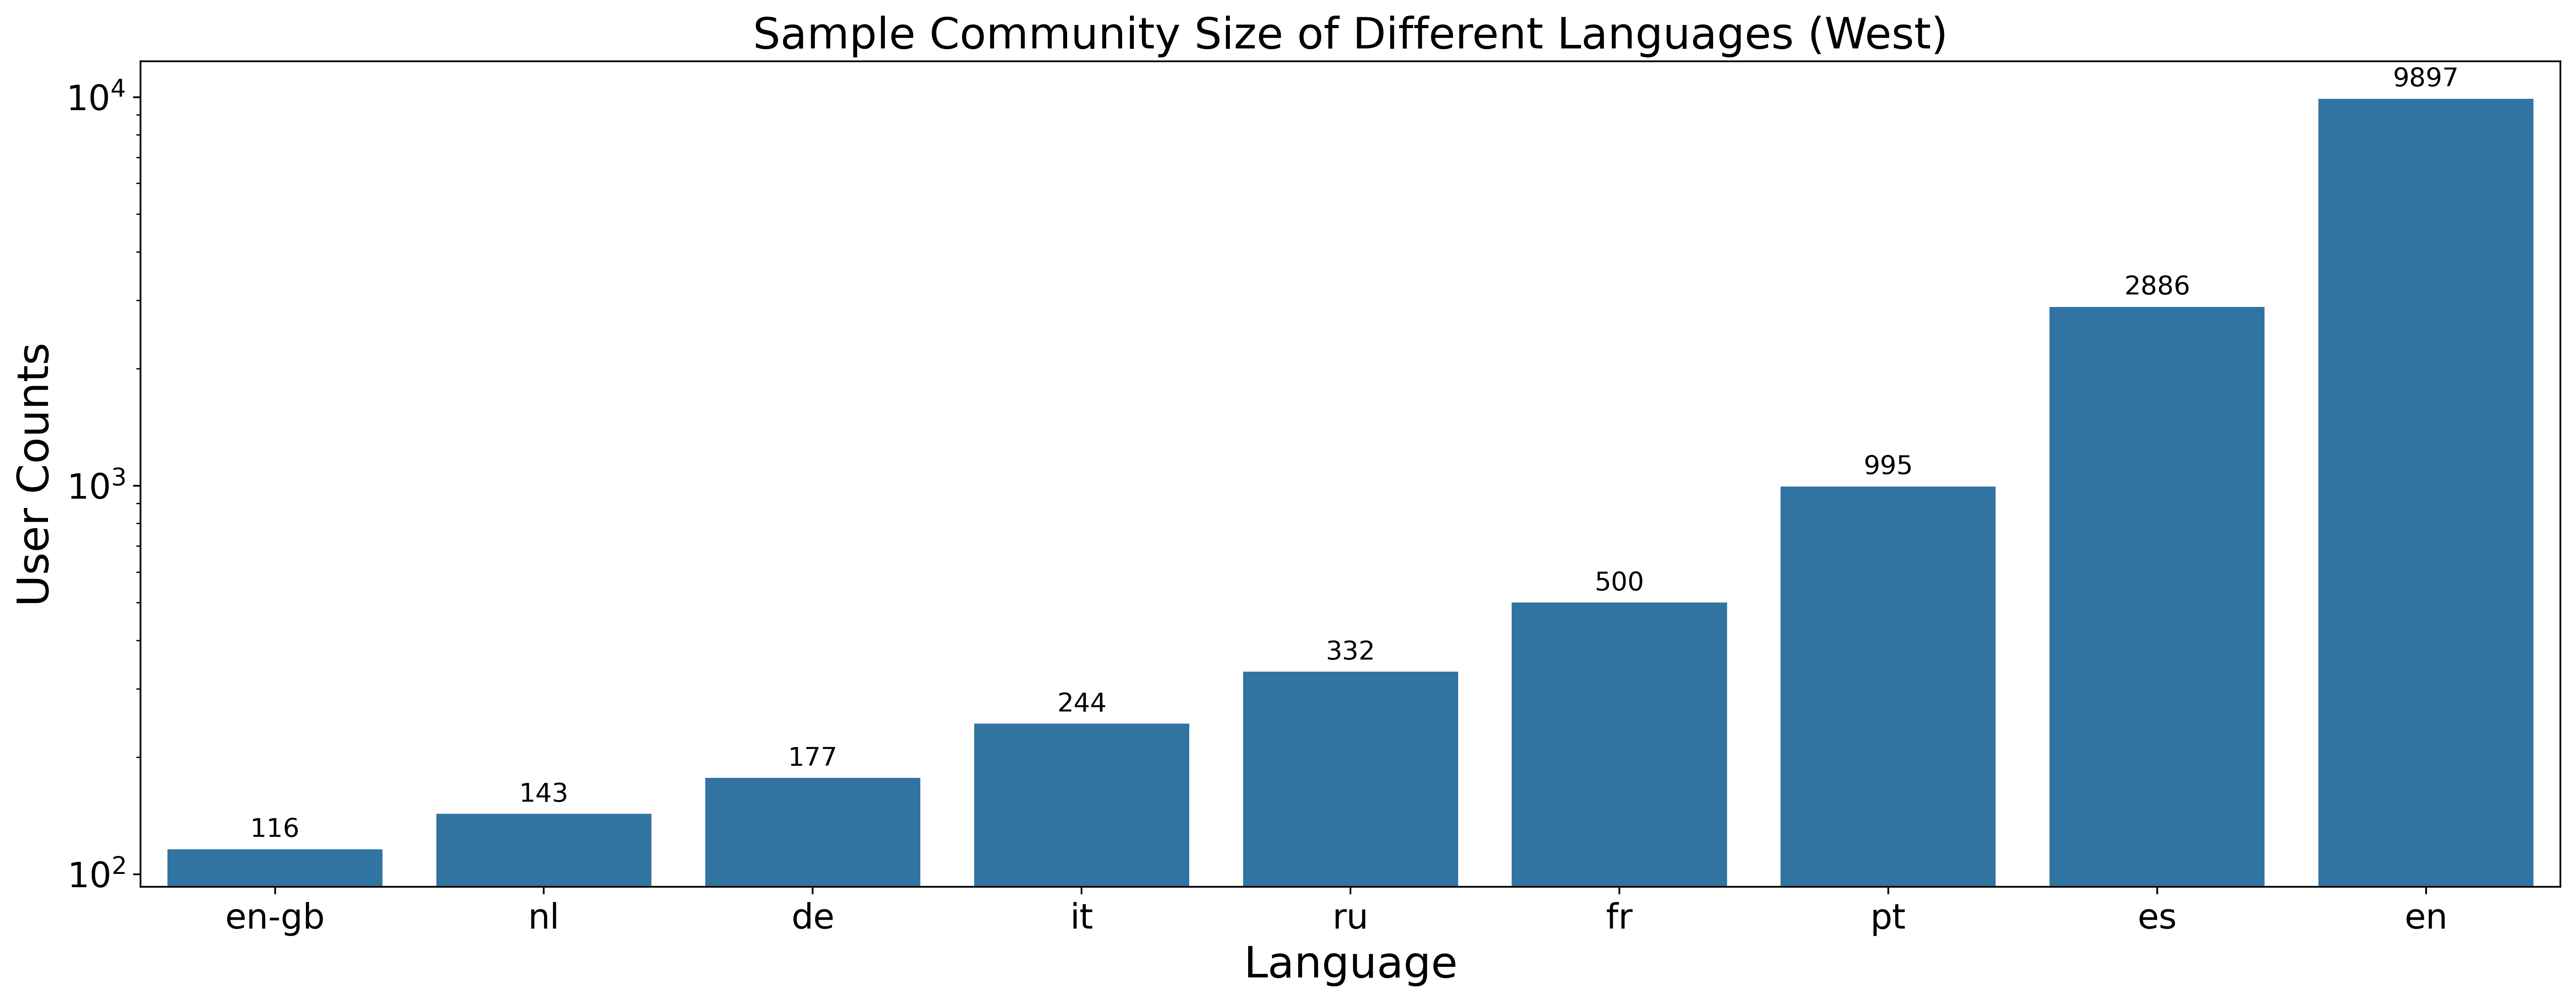

In [16]:
fig, ax = plt.subplots(figsize = (20, 7), dpi = 400)

languages_stat_west = languages_stat[languages_stat['area']=='West']

ax.set(yscale = 'log')
splot = sns.barplot(x = languages_stat_west.index, y = languages_stat_west['user_count'], 
            color = sns.color_palette()[0], ax = ax, dodge = False)
ax.set_xlabel('Language', fontsize = 20)
ax.set_ylabel('User Counts', fontsize = 20)
ax.set_title('Sample Community Size of Different Languages (West)', fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize = 12) 

plt.show()

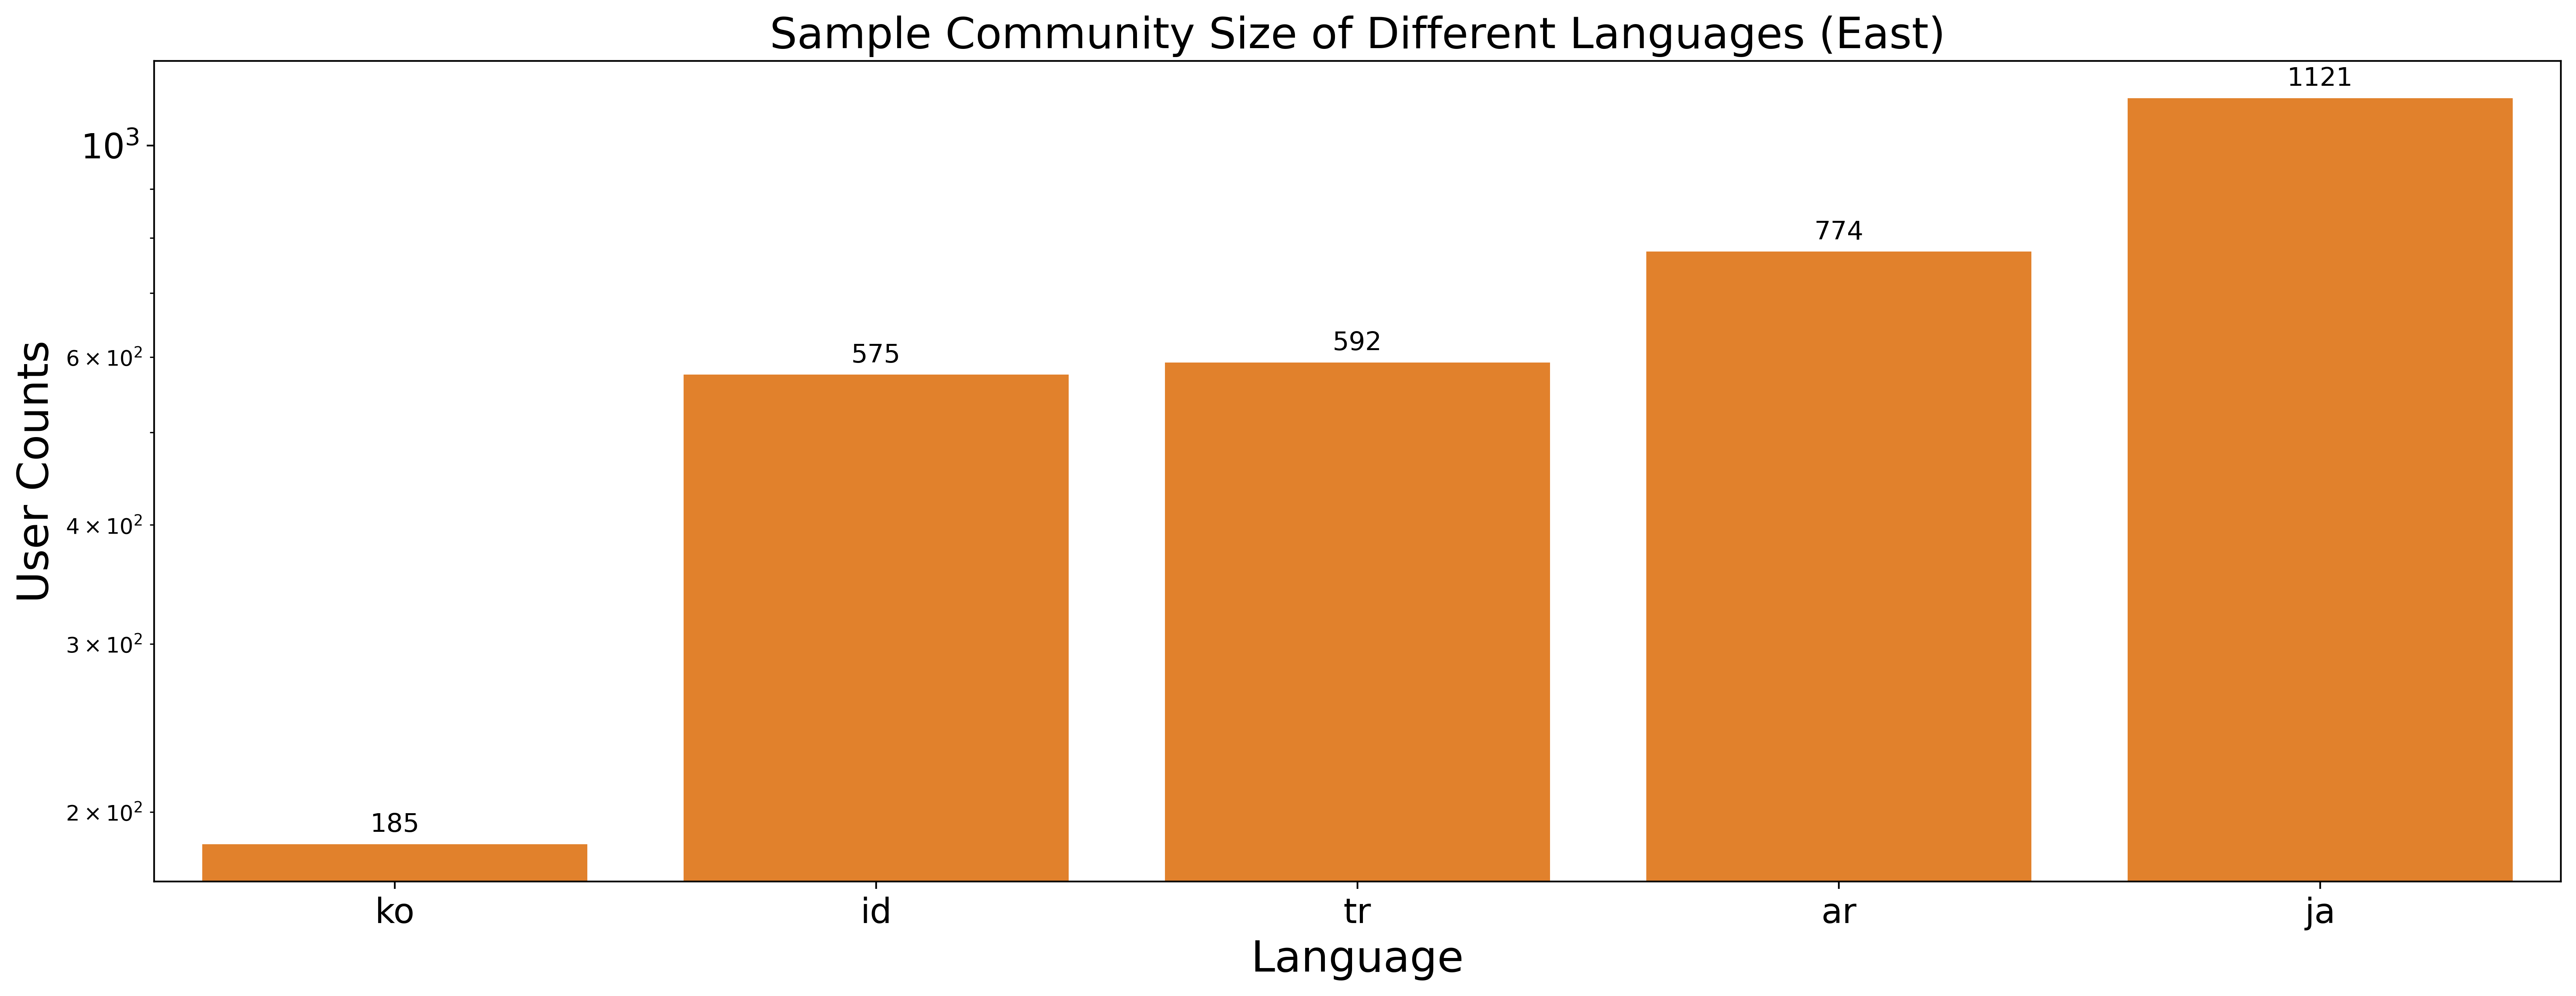

In [17]:
fig, ax = plt.subplots(figsize = (20, 7), dpi = 400)

languages_stat_east = languages_stat[languages_stat['area']=='East']

ax.set(yscale = 'log')
splot = sns.barplot(x = languages_stat_east.index, y = languages_stat_east['user_count'], 
            color = sns.color_palette()[1], ax = ax, dodge = False)
ax.set_xlabel('Language', fontsize = 20)
ax.set_ylabel('User Counts', fontsize = 20)
ax.set_title('Sample Community Size of Different Languages (East)', fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize = 12,) 

plt.show()

### Data Exploration

From the figures below, we can understand the distribution of the features of different languages.

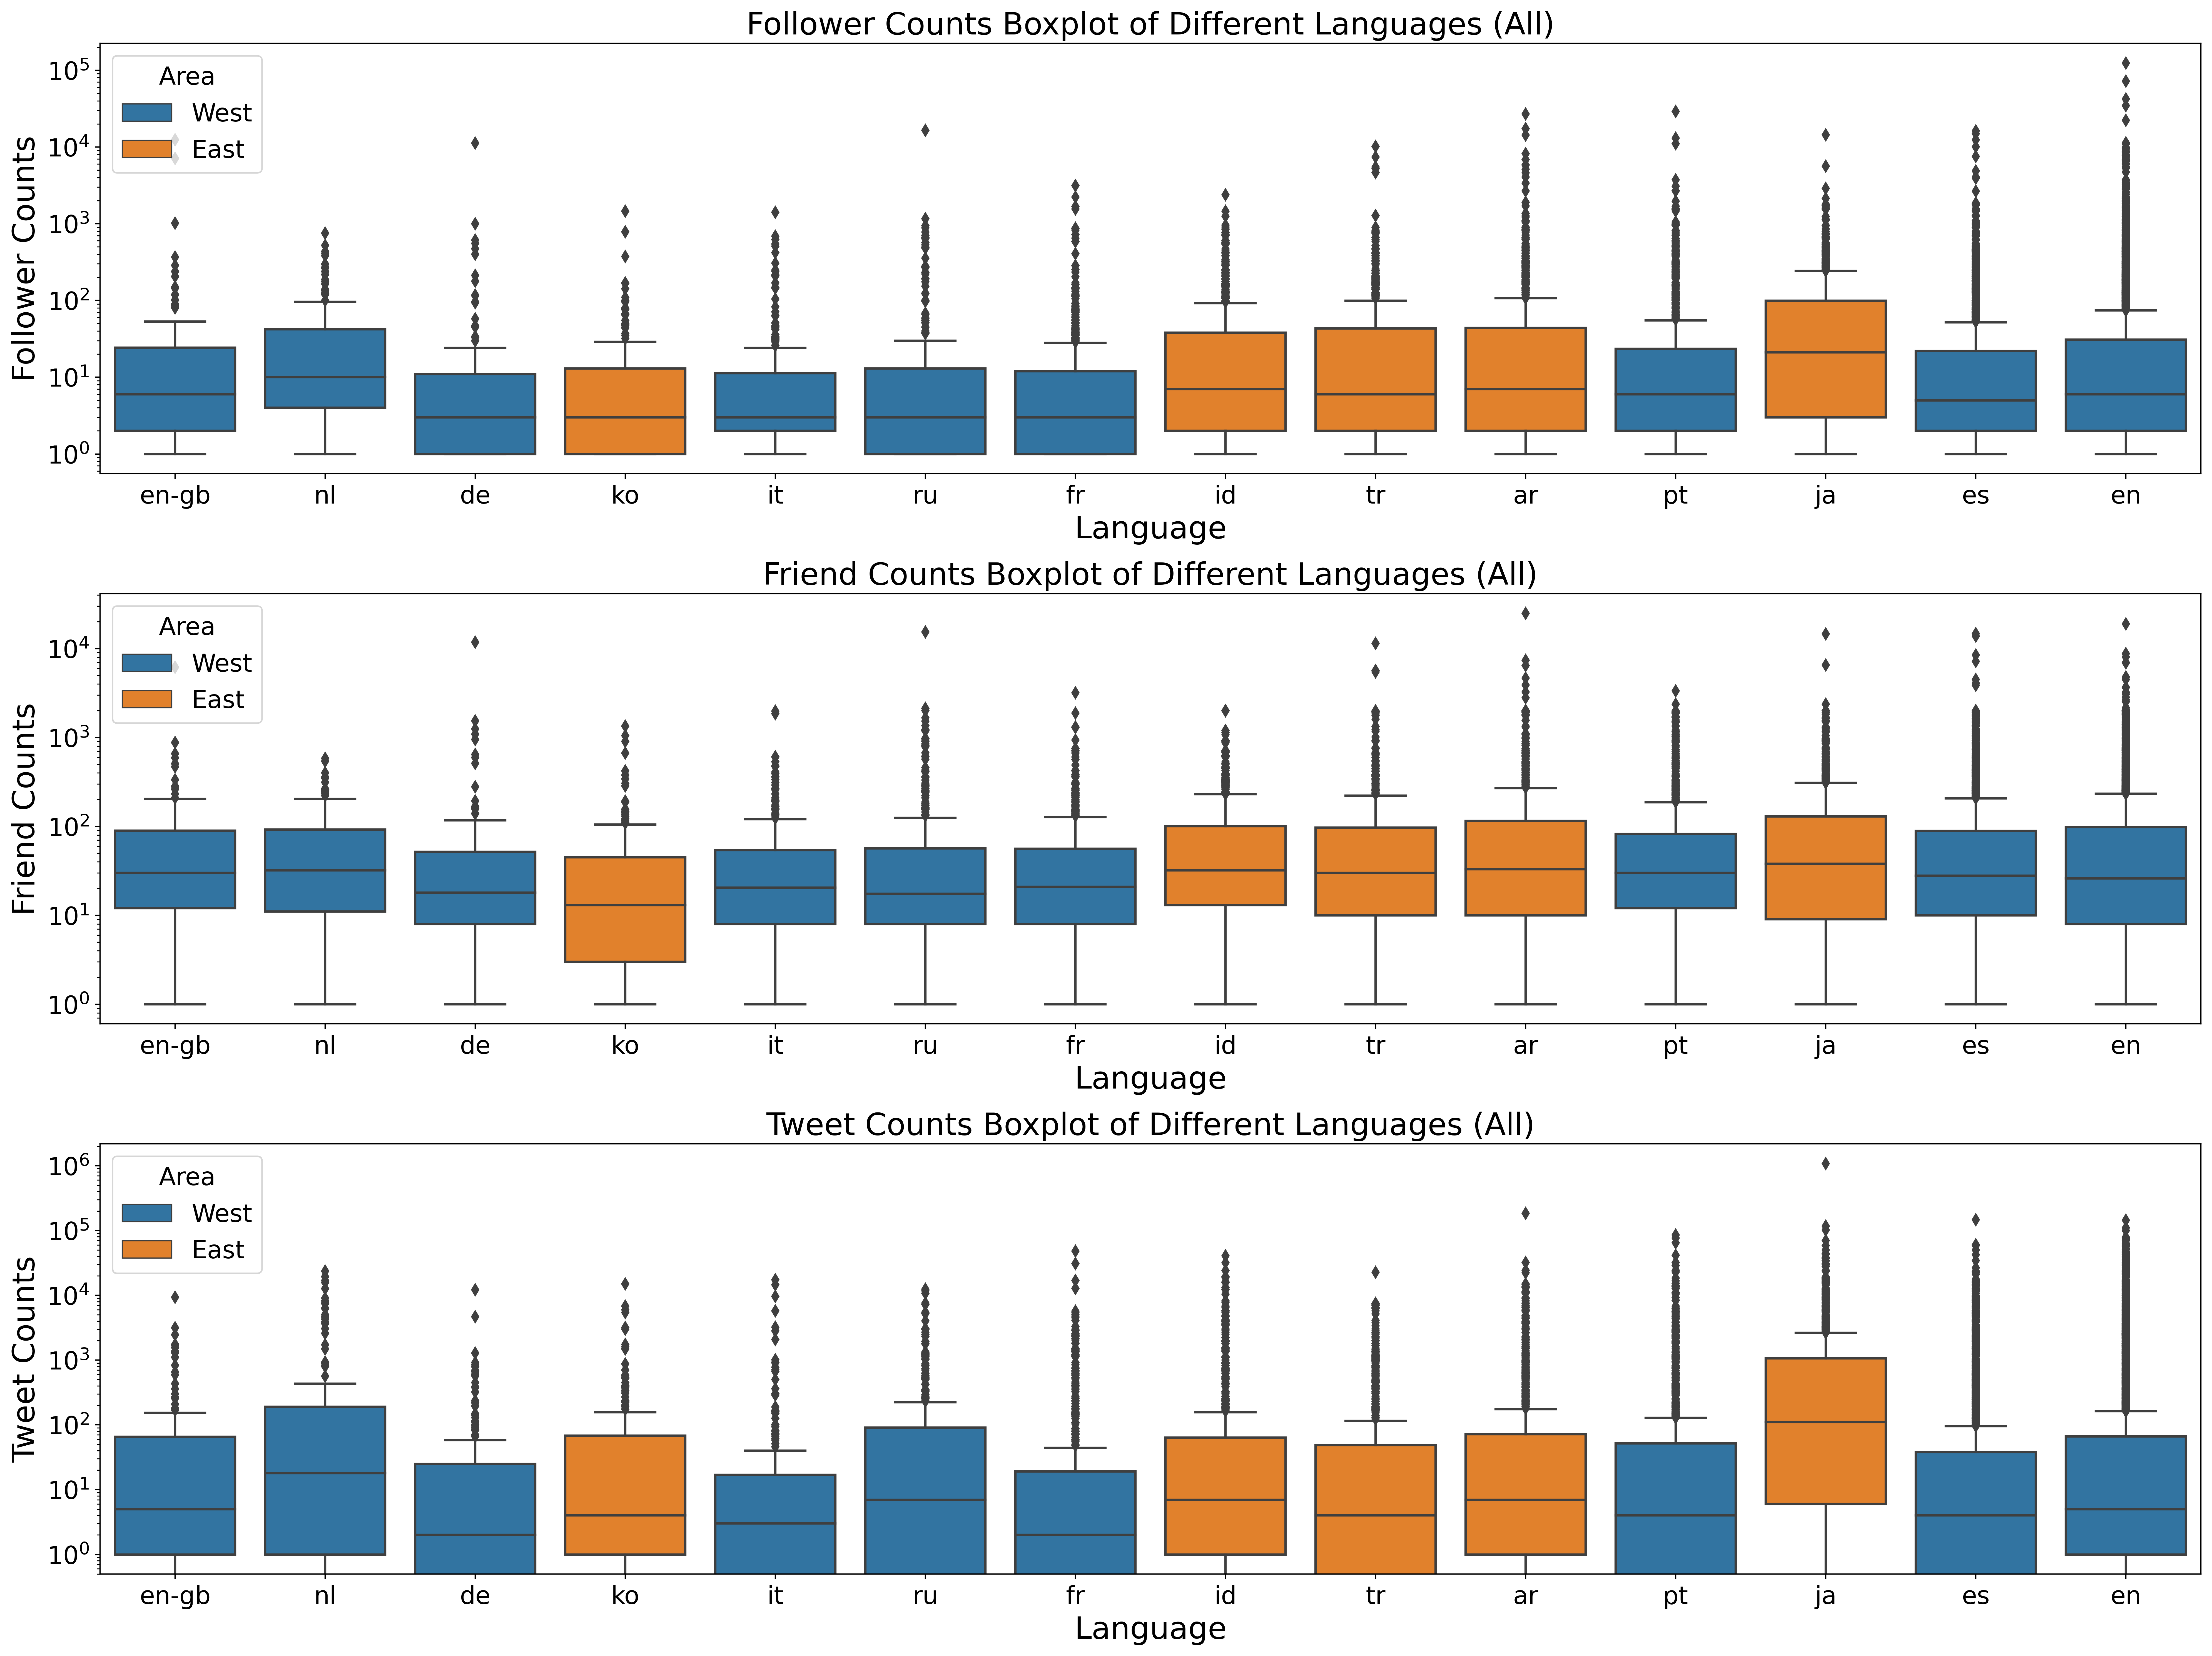

In [18]:
language_order = languages_stat.index.tolist()

fig, ax = plt.subplots(3, 1, figsize = (20, 15), dpi = 400)

ax[0].set(yscale="log")
sns.boxplot(x = 'lang', y = 'followers_count', data = languages, order = language_order, ax = ax[0],
           hue = 'area', dodge = False)
ax[0].set_xlabel('Language', fontsize = 20)
ax[0].set_ylabel('Follower Counts', fontsize = 20)
ax[0].set_title('Follower Counts Boxplot of Different Languages (All)', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)
ax[0].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

ax[1].set(yscale="log")
sns.boxplot(x = 'lang', y = 'friends_count', data = languages, order = language_order, ax = ax[1],
           hue = 'area', dodge = False)
ax[1].set_xlabel('Language', fontsize = 20)
ax[1].set_ylabel('Friend Counts', fontsize = 20)
ax[1].set_title('Friend Counts Boxplot of Different Languages (All)', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)
ax[1].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

ax[2].set(yscale="log")
sns.boxplot(x = 'lang', y = 'statuses_count', data = languages, order = language_order, ax = ax[2],
           hue = 'area', dodge = False)
ax[2].set_xlabel('Language', fontsize = 20)
ax[2].set_ylabel('Tweet Counts', fontsize = 20)
ax[2].set_title('Tweet Counts Boxplot of Different Languages (All)', fontsize=20)
ax[2].xaxis.set_tick_params(labelsize=16)
ax[2].yaxis.set_tick_params(labelsize=16)
ax[2].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

fig.tight_layout()
plt.show()

Beware of the log scale. 

For follower and friend counts, the box plots for all languages are approximately quite close. But the 75-100% of the counts vary drastically for some languages. These few number of famous people have an exponentially large number of followers and friends which contributes to a really high count for languages like < en >. 

For the tweets, a clear dominance of the < ja > language is visible. 

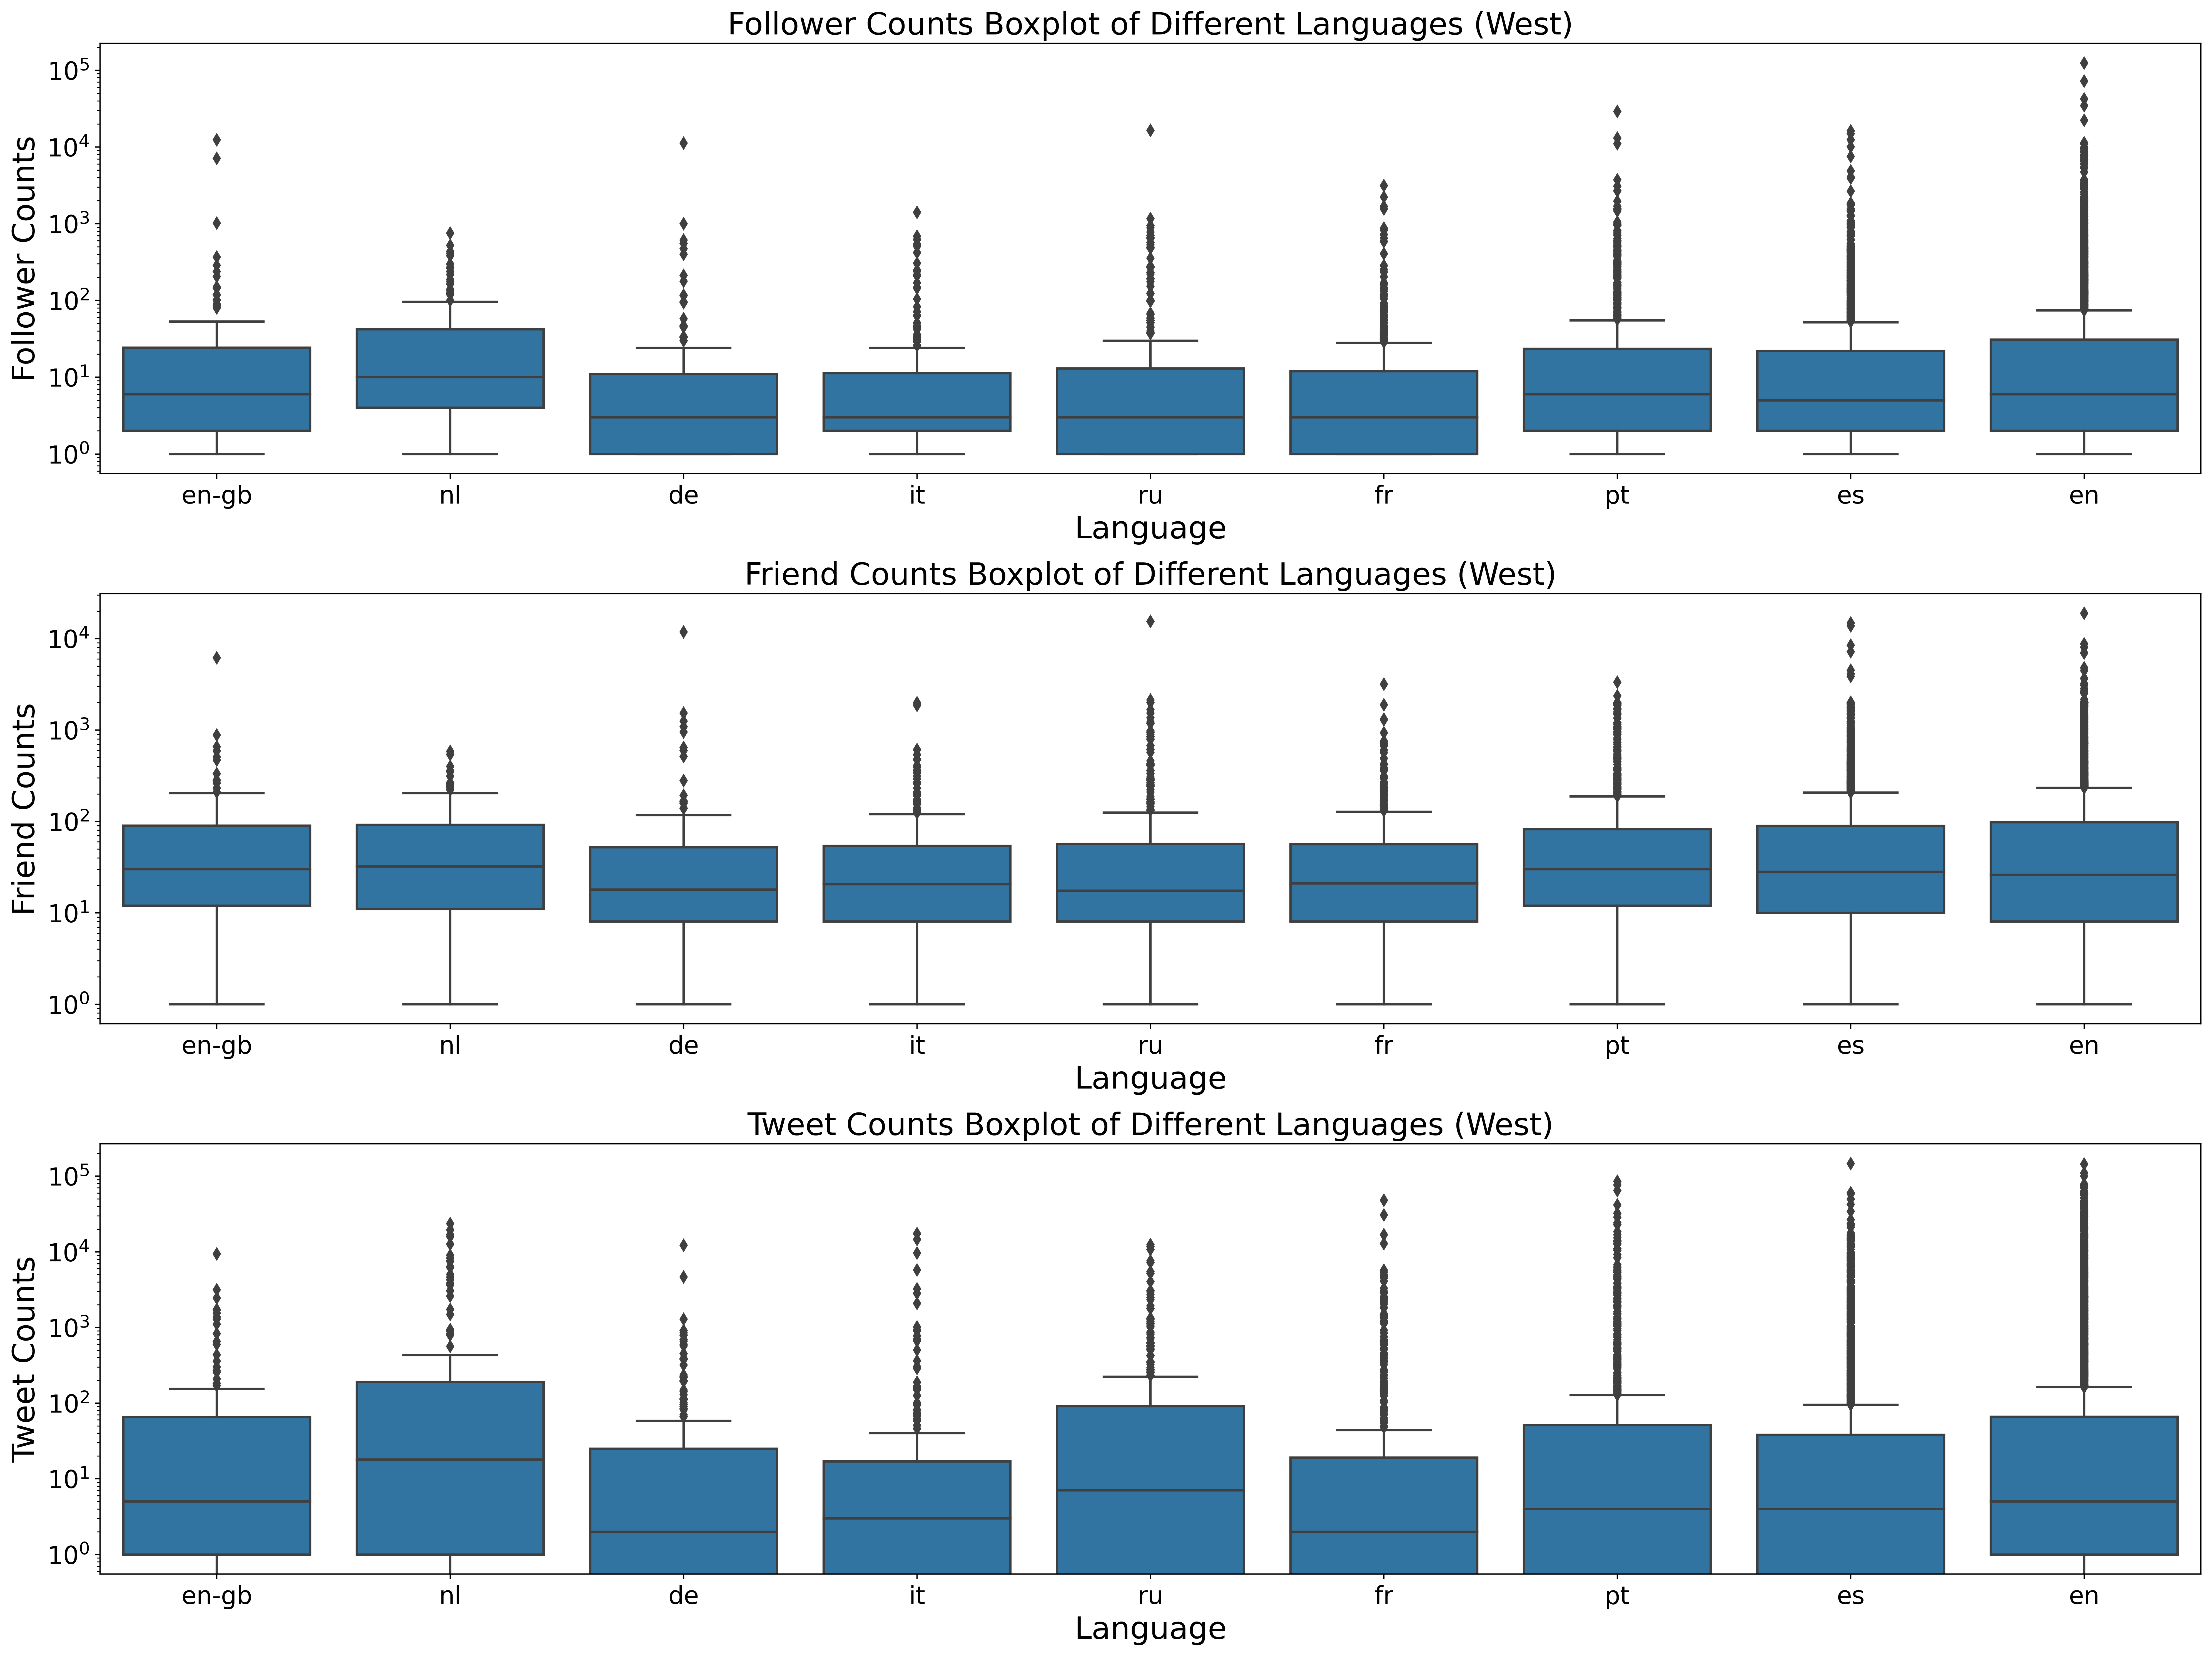

In [19]:
languages_west = languages[languages['area'] == 'West']
language_order = languages_stat_west.index.tolist()

fig, ax = plt.subplots(3, 1, figsize = (20, 15), dpi = 400)

ax[0].set(yscale="log")
sns.boxplot(x = 'lang', y = 'followers_count', data = languages_west, order = language_order, ax = ax[0],
            dodge = False, color = sns.color_palette()[0])
ax[0].set_xlabel('Language', fontsize = 20)
ax[0].set_ylabel('Follower Counts', fontsize = 20)
ax[0].set_title('Follower Counts Boxplot of Different Languages (West)', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)

ax[1].set(yscale="log")
sns.boxplot(x = 'lang', y = 'friends_count', data = languages_west, order = language_order, ax = ax[1],
           dodge = False, color = sns.color_palette()[0])
ax[1].set_xlabel('Language', fontsize = 20)
ax[1].set_ylabel('Friend Counts', fontsize = 20)
ax[1].set_title('Friend Counts Boxplot of Different Languages (West)', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)

ax[2].set(yscale="log")
sns.boxplot(x = 'lang', y = 'statuses_count', data = languages_west, order = language_order, ax = ax[2],
           dodge = False, color = sns.color_palette()[0])
ax[2].set_xlabel('Language', fontsize = 20)
ax[2].set_ylabel('Tweet Counts', fontsize = 20)
ax[2].set_title('Tweet Counts Boxplot of Different Languages (West)', fontsize=20)
ax[2].xaxis.set_tick_params(labelsize=16)
ax[2].yaxis.set_tick_params(labelsize=16)

fig.tight_layout()
plt.show()

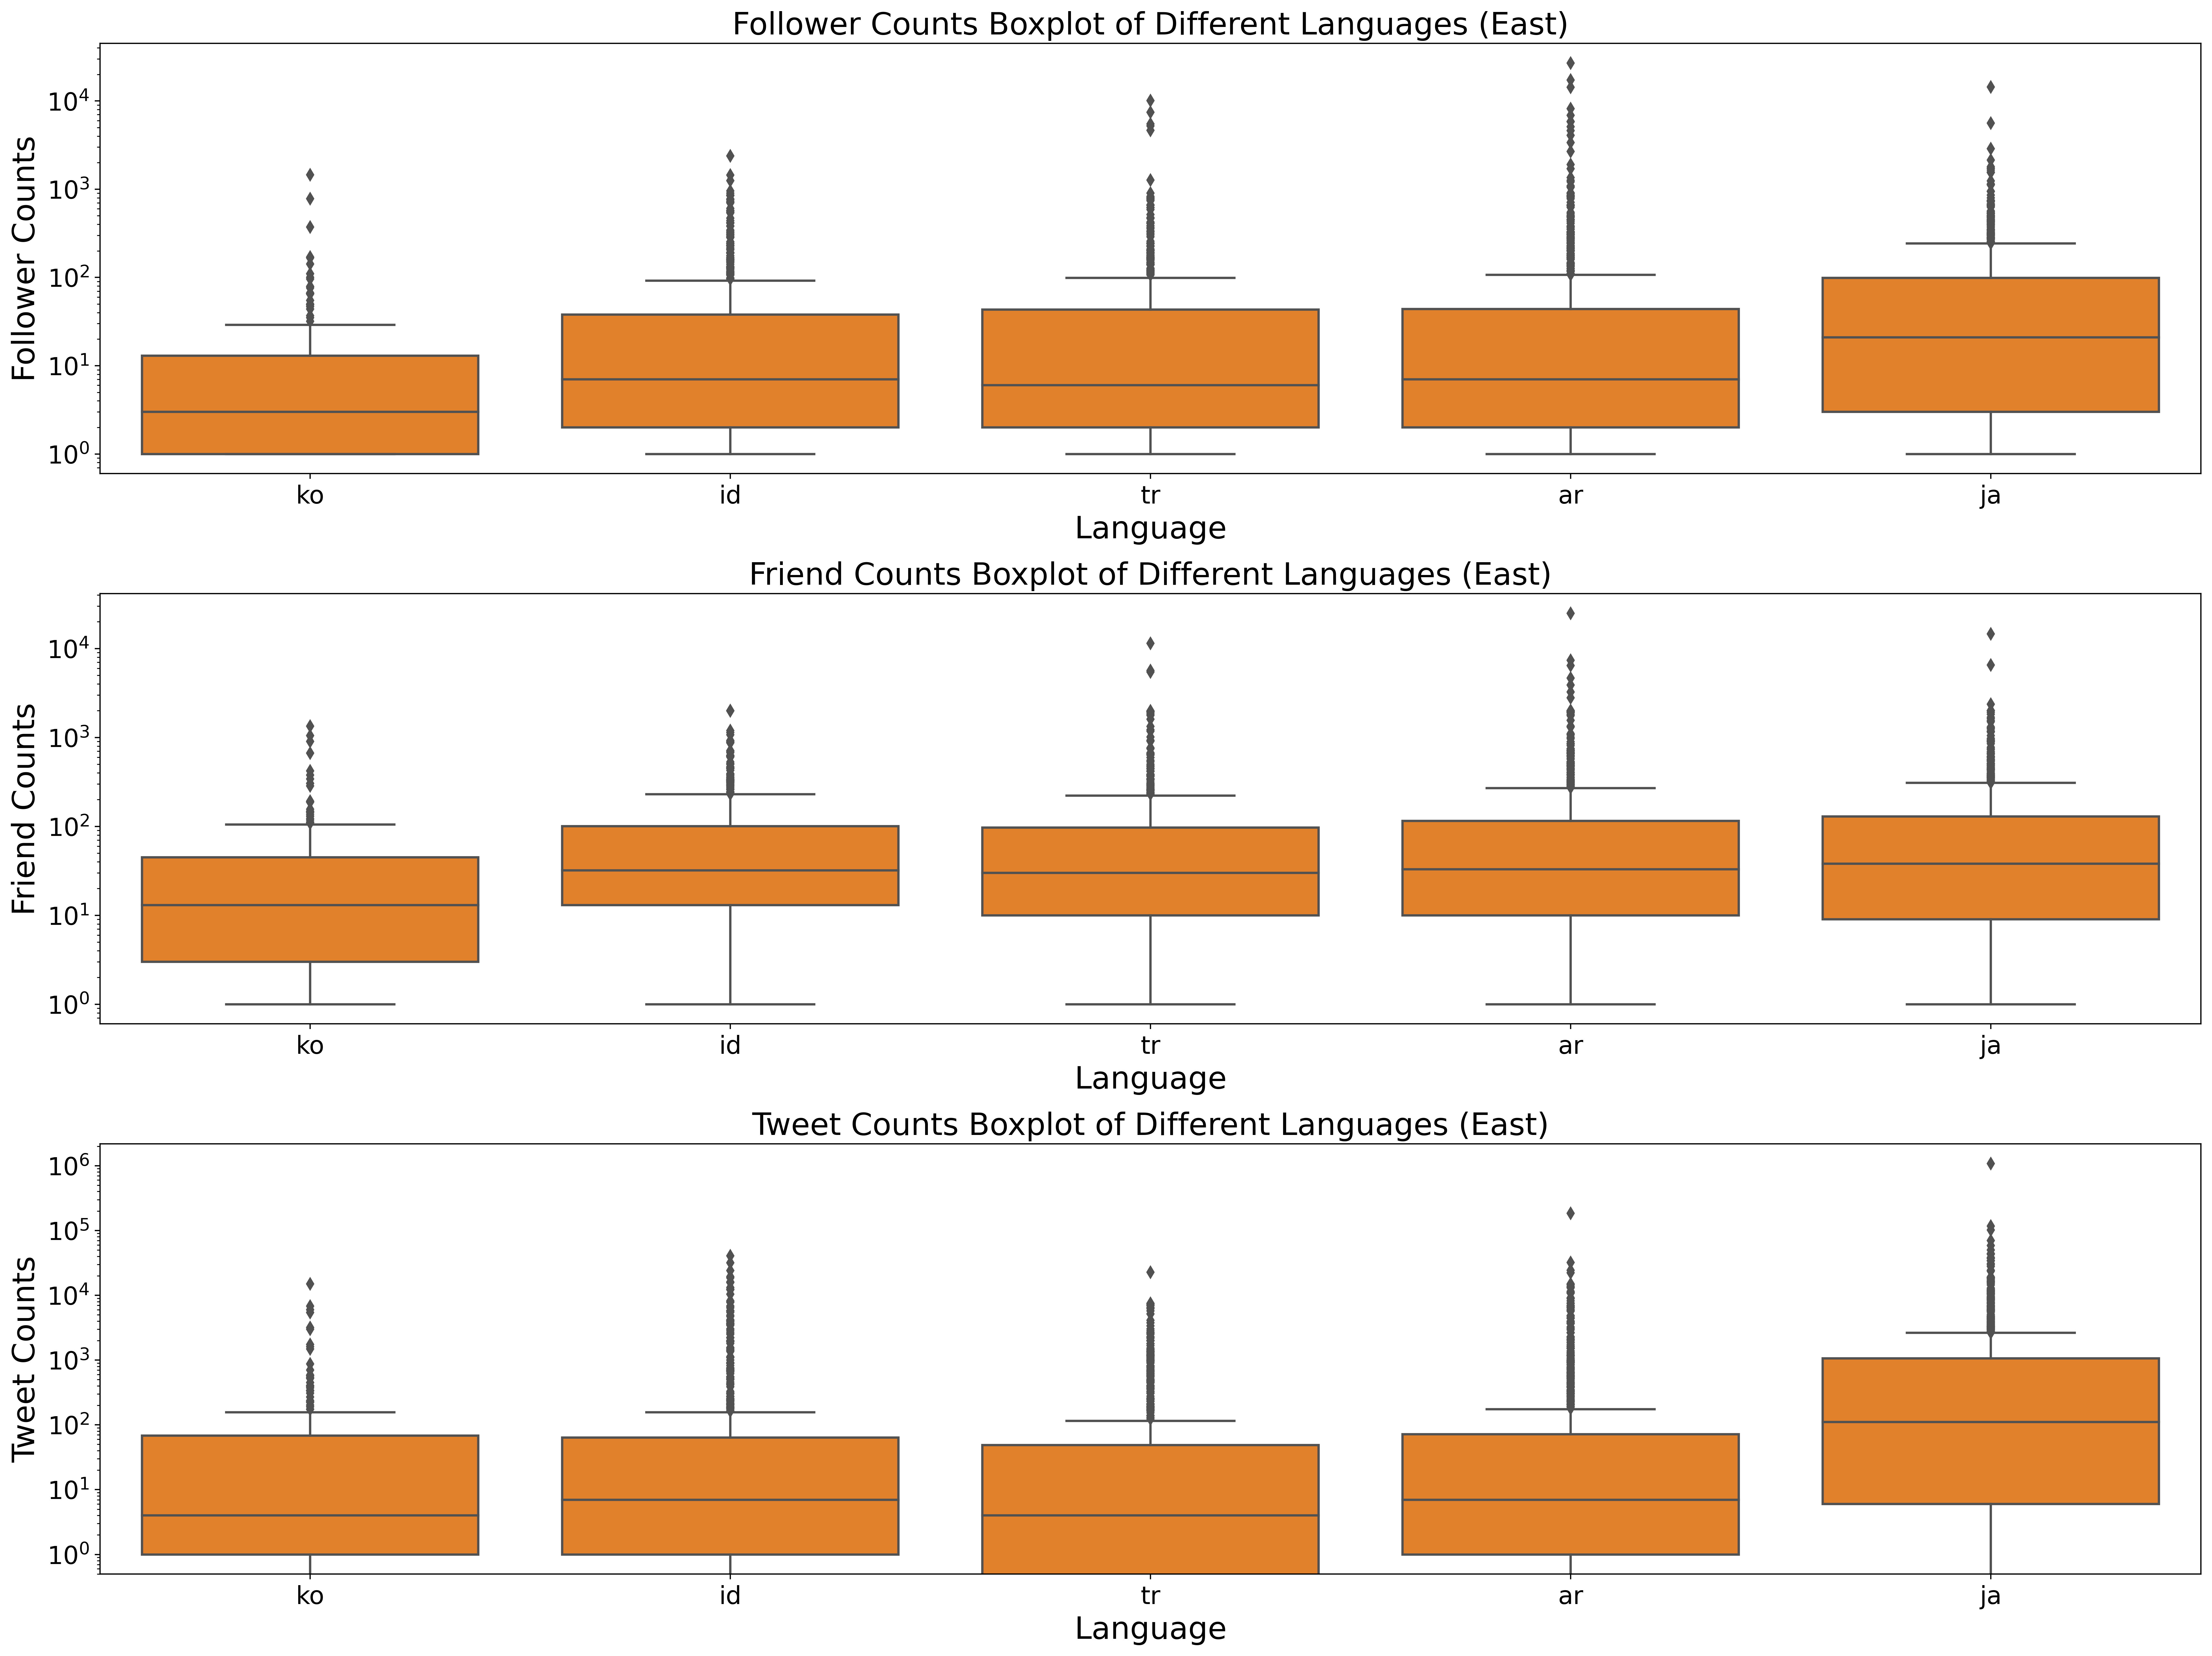

In [20]:
languages_east = languages[languages['area'] == 'East']
language_order = languages_stat_east.index.tolist()

fig, ax = plt.subplots(3, 1, figsize = (20, 15), dpi = 400)

ax[0].set(yscale="log")
sns.boxplot(x = 'lang', y = 'followers_count', data = languages_east, order = language_order, ax = ax[0],
           dodge = False, color = sns.color_palette()[1])
ax[0].set_xlabel('Language', fontsize = 20)
ax[0].set_ylabel('Follower Counts', fontsize = 20)
ax[0].set_title('Follower Counts Boxplot of Different Languages (East)', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)

ax[1].set(yscale="log")
sns.boxplot(x = 'lang', y = 'friends_count', data = languages_east, order = language_order, ax = ax[1],
           dodge = False, color = sns.color_palette()[1])
ax[1].set_xlabel('Language', fontsize = 20)
ax[1].set_ylabel('Friend Counts', fontsize = 20)
ax[1].set_title('Friend Counts Boxplot of Different Languages (East)', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)

ax[2].set(yscale="log")
sns.boxplot(x = 'lang', y = 'statuses_count', data = languages_east, order = language_order, ax = ax[2],
           dodge = False, color = sns.color_palette()[1])
ax[2].set_xlabel('Language', fontsize = 20)
ax[2].set_ylabel('Tweet Counts', fontsize = 20)
ax[2].set_title('Tweet Counts Boxplot of Different Languages (East)', fontsize=20)
ax[2].xaxis.set_tick_params(labelsize=16)
ax[2].yaxis.set_tick_params(labelsize=16)

fig.tight_layout()
plt.show()

### Relation Between Community Size and Each Feature

In the begining of our analysis, we would like to see if the community size are correlated to some features such as friends count or tweets count. The figure below and the **pearson's correlated coefficient** shows that no features are correlated to the community size.

0.07546723518134077
0.04494181246547454
0.0859491562826639


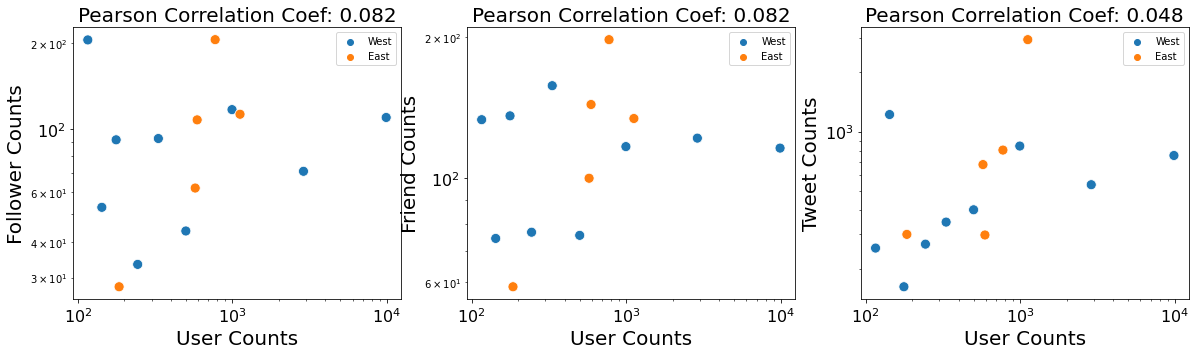

In [21]:
fig, ax = plt.subplots(1, 3, figsize = (20, 5))

ax[0].set(xscale="log", yscale='log')
sns.scatterplot(x = 'user_count', y = 'followers_count', hue=languages_stat.area.tolist(),
                data = languages_stat, ax = ax[0], s=100)
ax[0].set_xlabel('User Counts', fontsize = 20)
ax[0].set_ylabel('Follower Counts', fontsize = 20)
ax[0].set_title('Pearson Correlation Coef: 0.082', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)

ax[1].set(xscale="log", yscale='log')
sns.scatterplot(x = 'user_count', y = 'friends_count', hue=languages_stat.area.tolist(),
                data = languages_stat, ax = ax[1], s = 100)
ax[1].set_xlabel('User Counts', fontsize = 20)
ax[1].set_ylabel('Friend Counts', fontsize = 20)
ax[1].set_title('Pearson Correlation Coef: 0.082', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)

ax[2].set(xscale="log", yscale='log')
sns.scatterplot(x = 'user_count', y = 'statuses_count', hue=languages_stat.area.tolist(), 
                data = languages_stat, ax = ax[2], s=100)
ax[2].set_xlabel('User Counts', fontsize = 20)
ax[2].set_ylabel('Tweet Counts', fontsize = 20)
ax[2].set_title('Pearson Correlation Coef: 0.048', fontsize=20)
ax[2].xaxis.set_tick_params(labelsize=16)
ax[2].yaxis.set_tick_params(labelsize=16)

print(languages_stat['user_count'].corr(languages_stat['followers_count']))
print(languages_stat['user_count'].corr(languages_stat['friends_count']))
print(languages_stat['user_count'].corr(languages_stat['statuses_count']))

### Data Exploration for Cultures

To figure out whether the difference exists among western countries and eastern countries. We then group the users by the area, and check the distribution of each feature.

In [22]:
languages.groupby('area')[['followers_count', 'friends_count', 'statuses_count']].mean().reset_index()

area  followers_count  friends_count  statuses_count
0  East       120.052048     140.611026     1395.361565
1  West        99.021714     116.018182      685.419817

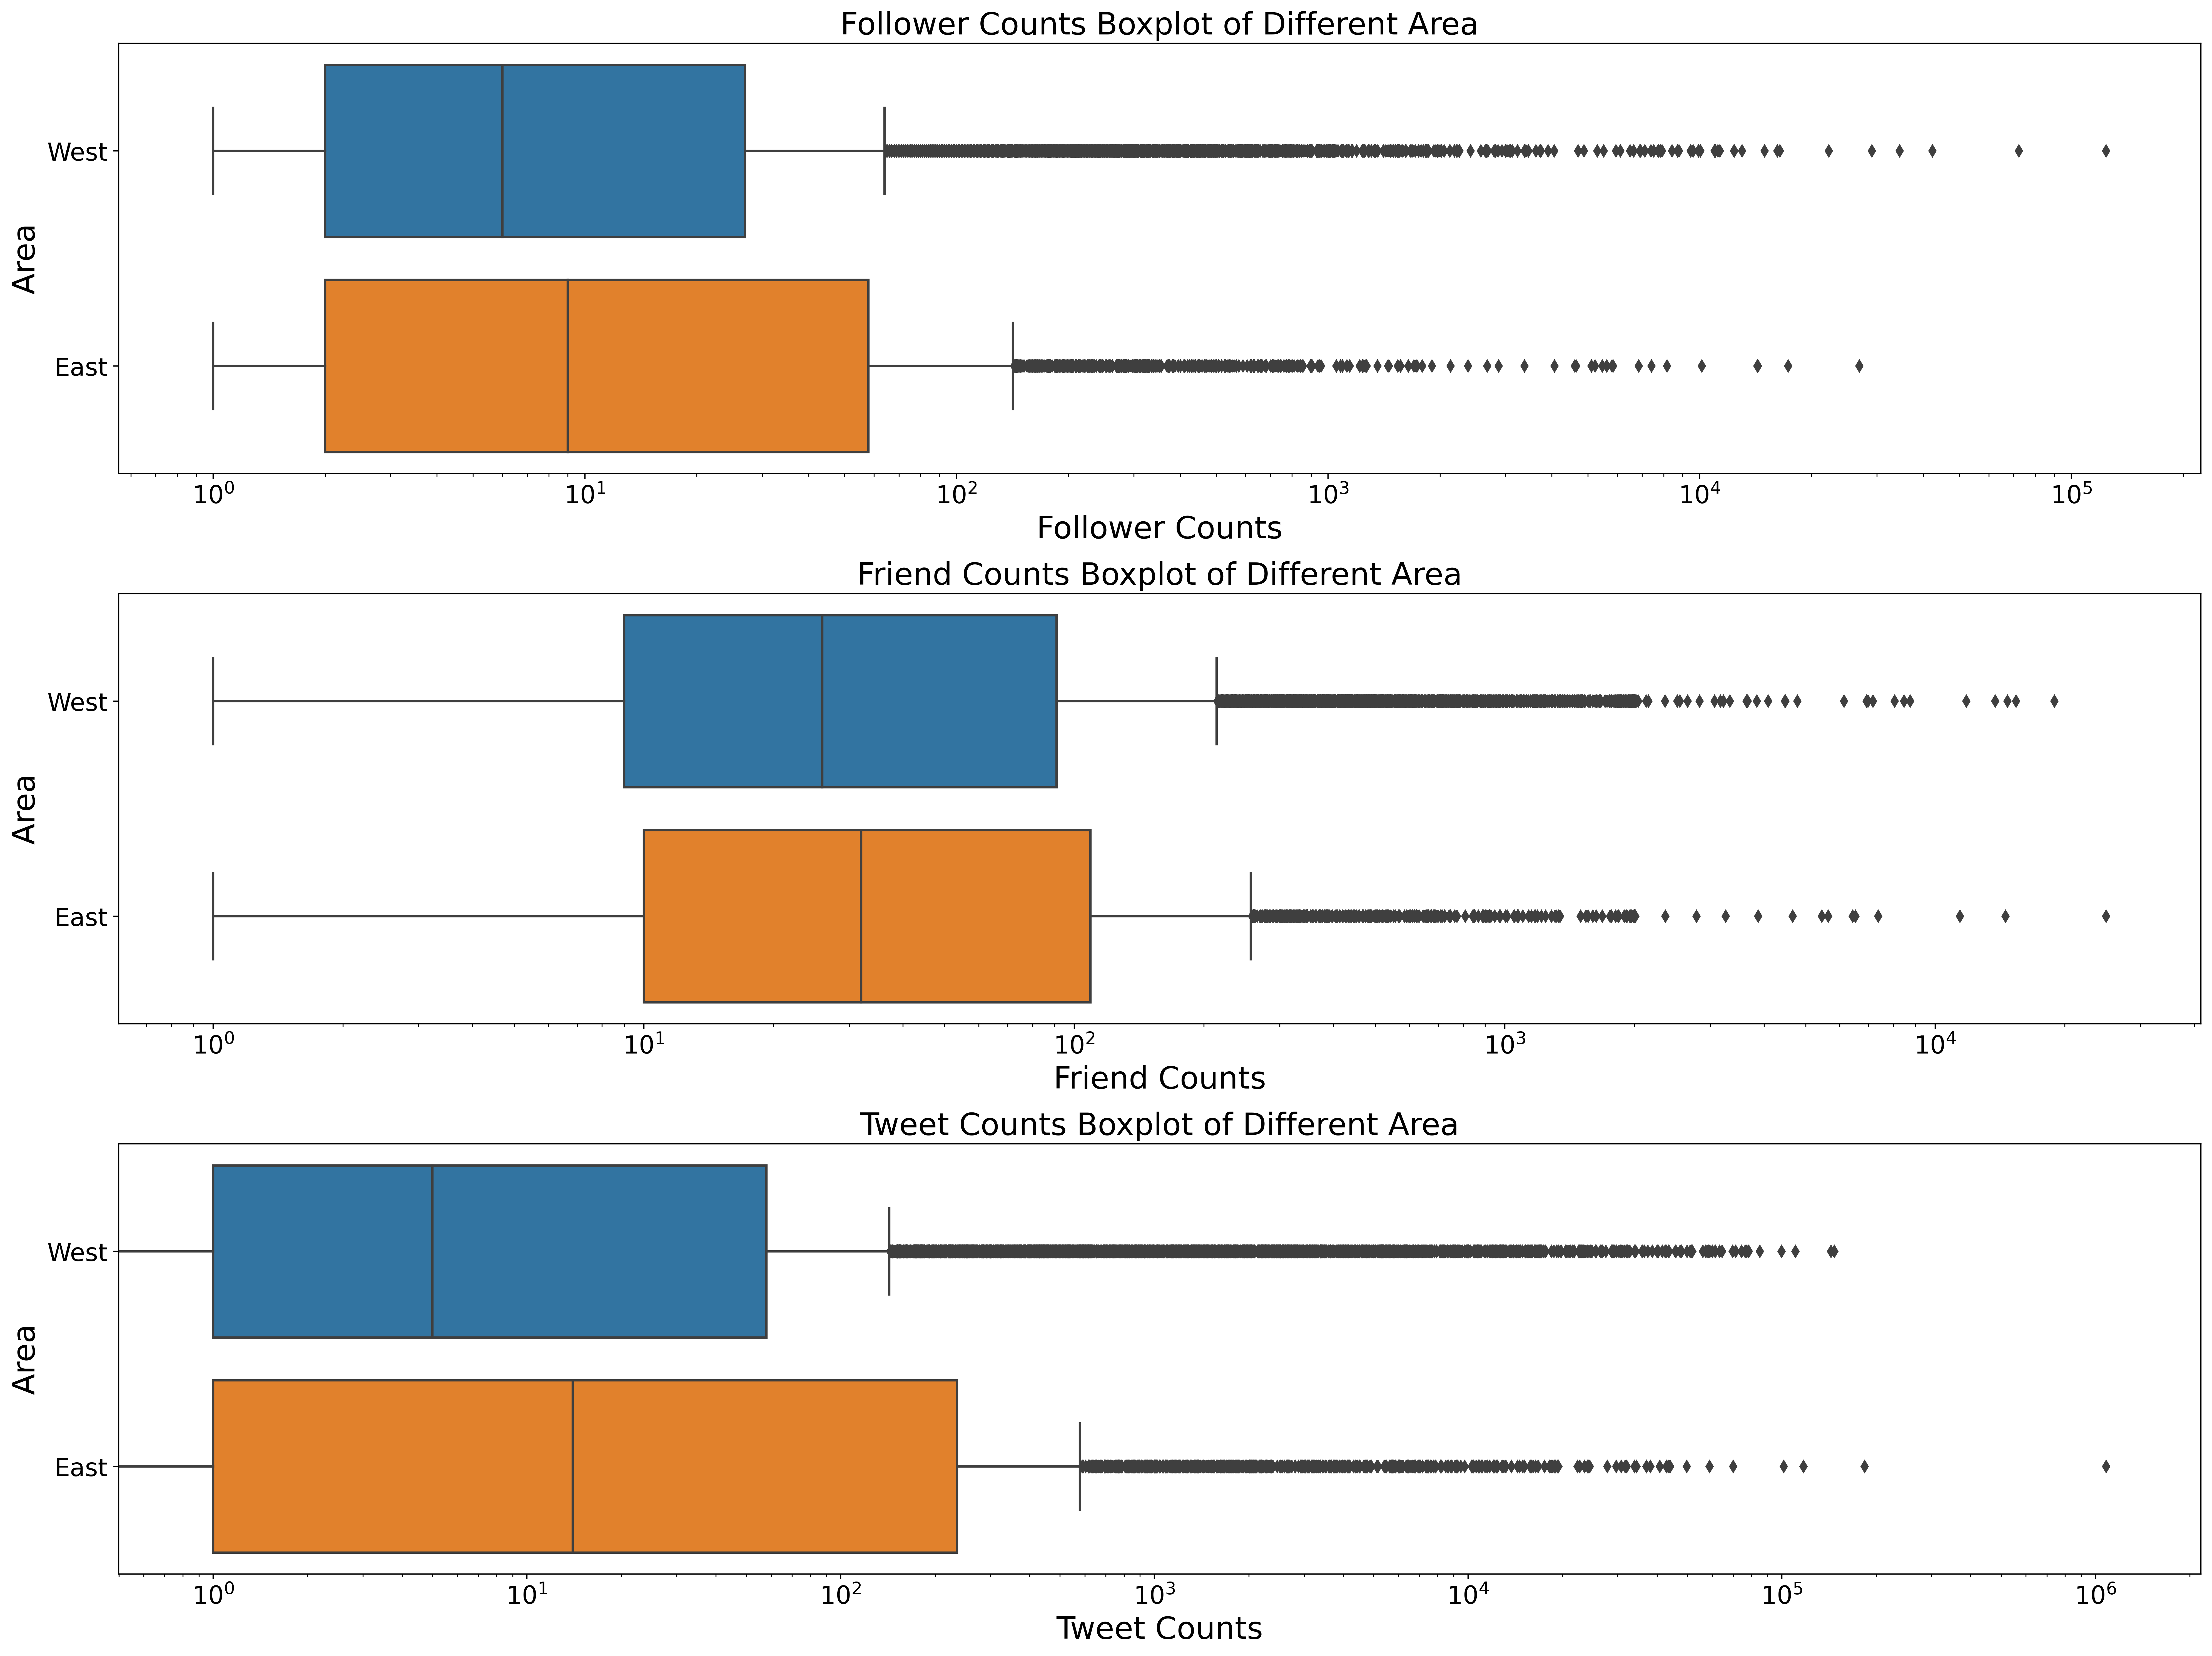

In [23]:
fig, ax = plt.subplots(3, 1, figsize = (20, 15), dpi = 400)

ax[0].set(xscale="log")
sns.boxplot( x = 'followers_count', y = 'area', data = languages, ax = ax[0])
ax[0].set_xlabel('Follower Counts', fontsize = 20)
ax[0].set_ylabel('Area', fontsize = 20)
ax[0].set_title('Follower Counts Boxplot of Different Area', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)

ax[1].set(xscale="log")
sns.boxplot( x = 'friends_count', y = 'area', data = languages, ax = ax[1])
ax[1].set_xlabel('Friend Counts', fontsize = 20)
ax[1].set_ylabel('Area', fontsize = 20)
ax[1].set_title('Friend Counts Boxplot of Different Area', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)

ax[2].set(xscale="log")
sns.boxplot( x = 'statuses_count', y = 'area',  data = languages, ax = ax[2])
ax[2].set_xlabel('Tweet Counts', fontsize = 20)
ax[2].set_ylabel('Area', fontsize = 20)
ax[2].set_title('Tweet Counts Boxplot of Different Area', fontsize=20)
ax[2].xaxis.set_tick_params(labelsize=16)
ax[2].yaxis.set_tick_params(labelsize=16)

fig.tight_layout()
plt.show()

There is a more even distribution of followers, friends and tweets in the eastern culture compared to the western culture. 
A larger proportion of counts belong to the top 25% users in the western culture, implying dominance by some famous users. 

For the number of tweets, there is a single point with surprisingly high number of tweets which is very apparent in the boxplot

In [24]:
a = languages_east['followers_count'].tolist()
b = languages_west['followers_count'].tolist()
print(stats.kstest(a, b))
print(stats.ttest_ind(a, b))

a = languages_east['friends_count'].tolist()
b = languages_west['friends_count'].tolist()
print(stats.kstest(a, b))
print(stats.ttest_ind(a, b))

a = languages_east['statuses_count'].tolist()
b = languages_west['statuses_count'].tolist()
print(stats.kstest(a, b))
print(stats.ttest_ind(a, b))


KstestResult(statistic=0.10258094053916644, pvalue=5.47912895011787e-25)
Ttest_indResult(statistic=0.8441801106567626, pvalue=0.3985796621993811)
KstestResult(statistic=0.046286283681289175, pvalue=2.0054680994890807e-05)
Ttest_indResult(statistic=2.768096230072353, pvalue=0.0056440773162006195)
KstestResult(statistic=0.1292969130029571, pvalue=1.7146579392578776e-39)
Ttest_indResult(statistic=4.030247506955485, pvalue=5.5940661272714486e-05)


### Case Study for different cultures

To delve deeper into the difference between eastern contries and western countries, we then try to reproduce some figures in the paper but group it by different cultures.

##### 1. Distribution of the number of tweets per user

Figures show the distribution of eastern countries and western countries are almost the same.

In [25]:
user_profiles = pd.read_csv('../Data/EgoAlterProfiles.txt', sep = '\t')

In [26]:
user_profiles = user_profiles[user_profiles['IsEgo'] == True]
user_profiles['lang'] = user_profiles['lang'].str.lower()

In [27]:
western_language = ['bg', 'ca', 'cs', 'da', 'de', 'el', 'en', 'en-au', 'en-gb', 'es', 'es-mx', 'eu', 'fa',
                 'fi',  'fr', 'he', 'hi', 'hr', 'hu',   'it', 'ka', 'lv', 'nb', 'nl', 'no', 'pl', 'pt',
                 'pt-pt', 'ro', 'ru', 'sr', 'sv', 'uk']

eastern_langauge = ['ar', 'az', 'fil', 'id', 'in', 'ja', 'ko', 'ms', 'msa', 'th', 'tr', 'vi' , 'zh', 'zh-cn',
                    'zh-hans', 'zh-hant', 'zh-tw']

In [28]:
# filter the ego user and sort it by 'statuses_count'
ego = user_profiles[user_profiles['IsEgo'] == True]
ego_west = user_profiles[user_profiles['lang'].isin(western_language)]
ego_west = ego_west.sort_values(by = ['statuses_count'], ascending = False).reset_index(drop=True)

ego_east = user_profiles[user_profiles['lang'].isin(eastern_language)]
ego_east = ego_east.sort_values(by = ['statuses_count'], ascending = False).reset_index(drop=True)

# check the number of egos and the data
#print(ego_west.shape)
#ego_west.head()

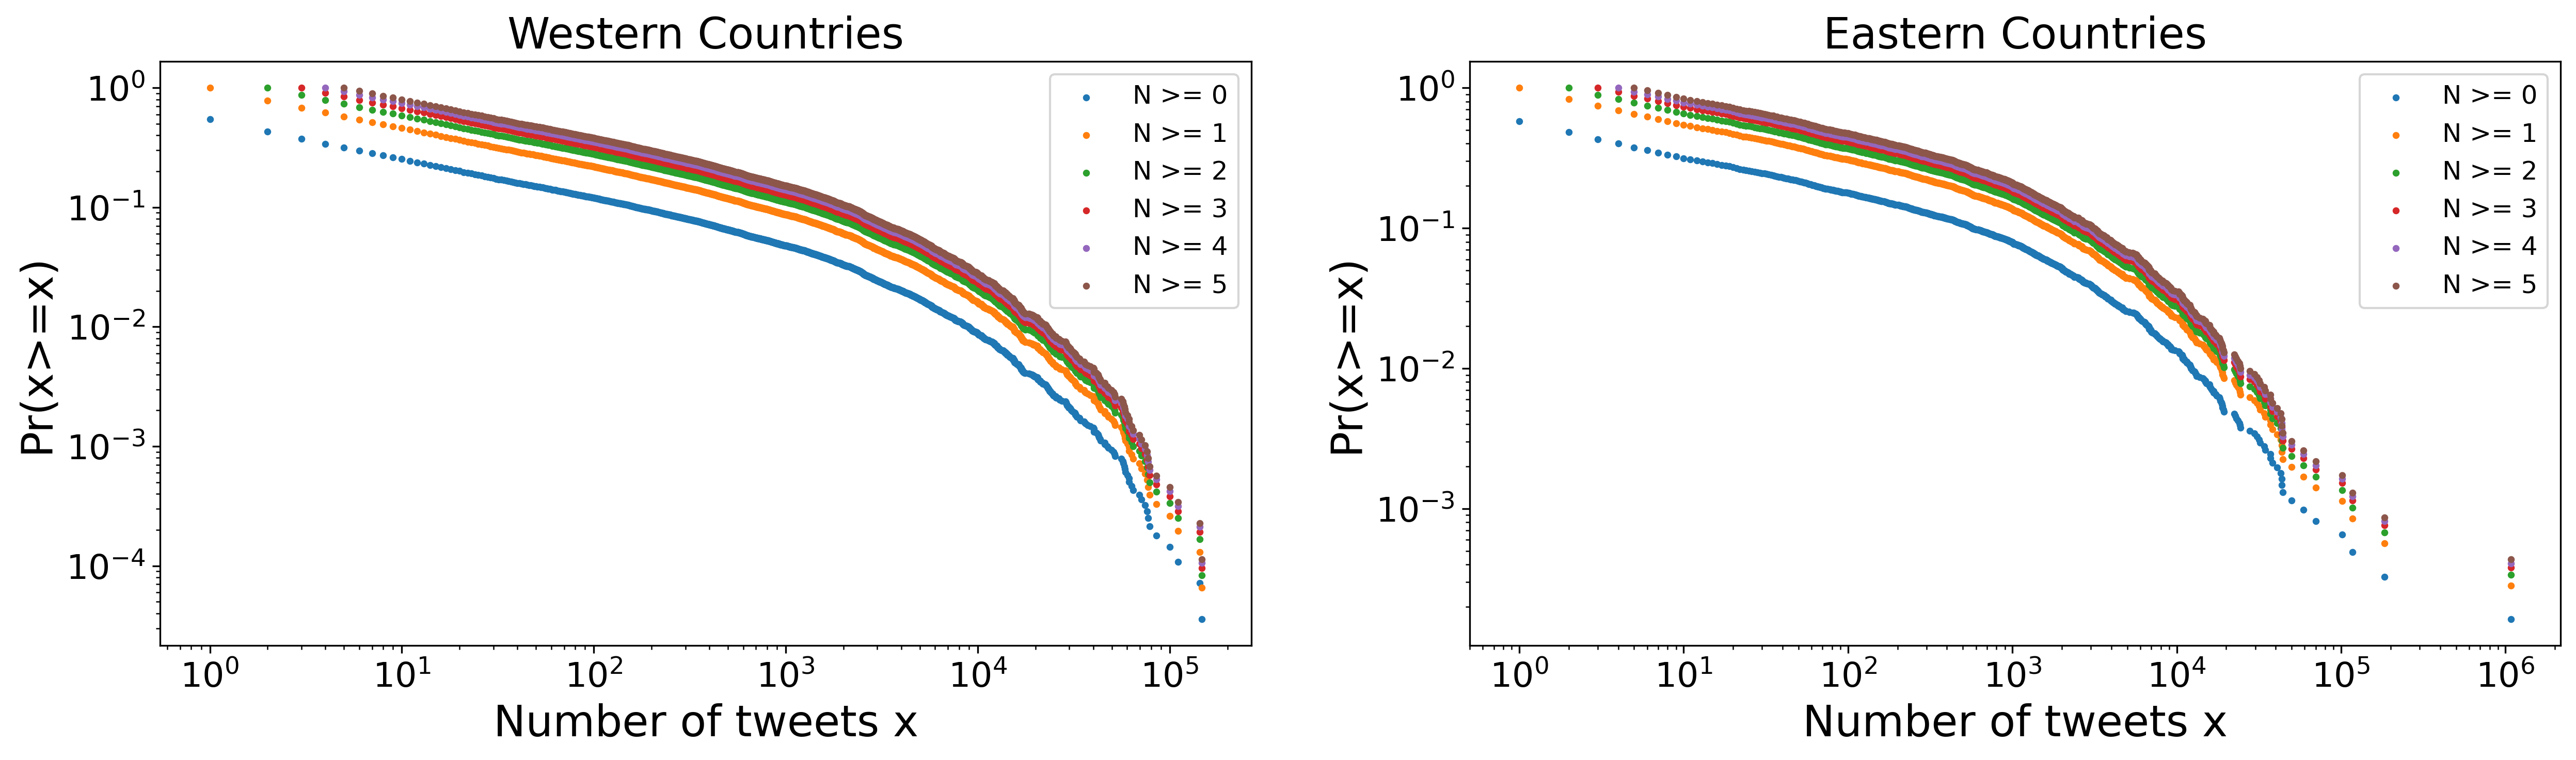

In [29]:
# prepare for the plot

fig, ax = plt.subplots(1, 2, figsize = (20, 5), dpi = 300)

# western plot

ax[0].set_title('Western Countries', fontsize = 20)
ax[0].set_xlabel('Number of tweets x', fontsize=20)
ax[0].set_ylabel('Pr(x>=x)', fontsize=20)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)

# calculate the number of people for each tweet counts 
temp = ego_west.groupby(ego_west['statuses_count']).count()['ID']
temp = temp.sort_index(ascending = False)

# loop the threshold from 0 to 5
for N in range(0, 6):
    temp = temp[temp.index >= N]
    tweet = temp.index.to_list()
    count = temp.to_list()
    total = np.sum(count)
    
    # cumulate tweet counts
    for i in range(1, len(tweet)):
        count[i]+=count[i-1]
    
    # calculate the ccdf for x (divide cumulated tweet counts by total number of tweets)
    for i in range(len(tweet)):
        count[i]/=total
    
    ax[0].scatter(tweet, count, s = 5, label = 'N >= {}'.format(N))

ax[0].legend(title="", fontsize=12, title_fontsize=12, loc = 1)

# eastern plot

ax[1].set_title('Eastern Countries', fontsize = 20)
ax[1].set_xlabel('Number of tweets x', fontsize=20)
ax[1].set_ylabel('Pr(x>=x)', fontsize=20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)

# calculate the number of people for each tweet counts 
temp = ego_east.groupby(ego_east['statuses_count']).count()['ID']
temp = temp.sort_index(ascending = False)

# loop the threshold from 0 to 5
for N in range(0, 6):
    temp = temp[temp.index >= N]
    tweet = temp.index.to_list()
    count = temp.to_list()
    total = np.sum(count)
    
    # cumulate tweet counts
    for i in range(1, len(tweet)):
        count[i]+=count[i-1]
    
    # calculate the ccdf for x (divide cumulated tweet counts by total number of tweets)
    for i in range(len(tweet)):
        count[i]/=total
    
    ax[1].scatter(tweet, count, s = 5, label = 'N >= {}'.format(N))

ax[1].legend(title="", fontsize=12, title_fontsize=12, loc = 1)

plt.show()

The distribution of number of tweets per user is quite similar for both. And the law of 80-20% is still plausible. 

##### 2. Daily and Weekly Rhythms of Twitter Activity

In [30]:
ego_timeline = pd.read_csv('../Data/EgoTimelines.txt', sep = '\t', encoding='latin-1')

Create a new column to save the time as a datetime object.

In [31]:
from datetime import datetime, timedelta

def convert_time(s: str):
    '''
    convert twitter time string format to a datetime object
    '''
    new_time = datetime.strptime(s, '%a %b %d %H:%M:%S %z %Y')
    return new_time

ego_timeline['time'] = ego_timeline['created_at'].astype('str').apply(convert_time)

Calibrate the time by utc offset.

In [32]:
# create a dictionary to map egoID to utc offset
ego['utc_offset'] = ego['utc_offset'].fillna(0)
offset = dict(zip(ego['ID'], ego['utc_offset']))

def get_offset(ID):
    '''
    obtain the utc offset from the dictionary by ID
    '''
    return offset[ID]

def convert_to_timedelta(s):
    '''
    convert float to timedelta datatype
    '''
    return timedelta(seconds = s)

# create a new column which represents the required offset
ego_timeline['utc_offset'] = ego_timeline['egoID'].apply(get_offset)

# add the offset to the time column
ego_timeline['time'] = ego_timeline['time'] + ego_timeline['utc_offset'].apply(convert_to_timedelta)

Extract week day and hour from the time column for later usage

In [33]:
def get_week_day(dt):
    return dt.strftime('%a')

def get_time(dt):
    return int(dt.strftime("%H"))

ego_timeline['week_day'] = ego_timeline['time'].apply(get_week_day)
ego_timeline['hour'] = ego_timeline['time'].apply(get_time)

#ego_timeline.head()

Create two new dataframe for tweet counts and active user counts.

In [34]:
ego_lang = dict(zip(ego['ID'], ego['lang'].isin(western_language)))

def add_area(id):
    if ego_lang[id]:
        return 'west'
    else:
        return 'east'

ego_timeline['area'] = ego_timeline['egoID'].apply(add_area)
ego_timeline_west = ego_timeline[ego_timeline['area'] == 'west']
ego_timeline_east = ego_timeline[ego_timeline['area'] == 'east']

In [35]:
tweet_time_west = ego_timeline_west.groupby( [ 'week_day', 'hour'] ).size().reset_index(name = 'count')
user_time_west = ego_timeline_west.groupby( [ 'week_day', 'hour'] )['egoID'].nunique().reset_index(name = 'count')
tweet_time_east = ego_timeline_east.groupby( [ 'week_day', 'hour'] ).size().reset_index(name = 'count')
user_time_east = ego_timeline_east.groupby( [ 'week_day', 'hour'] )['egoID'].nunique().reset_index(name = 'count')

Plot the figure.

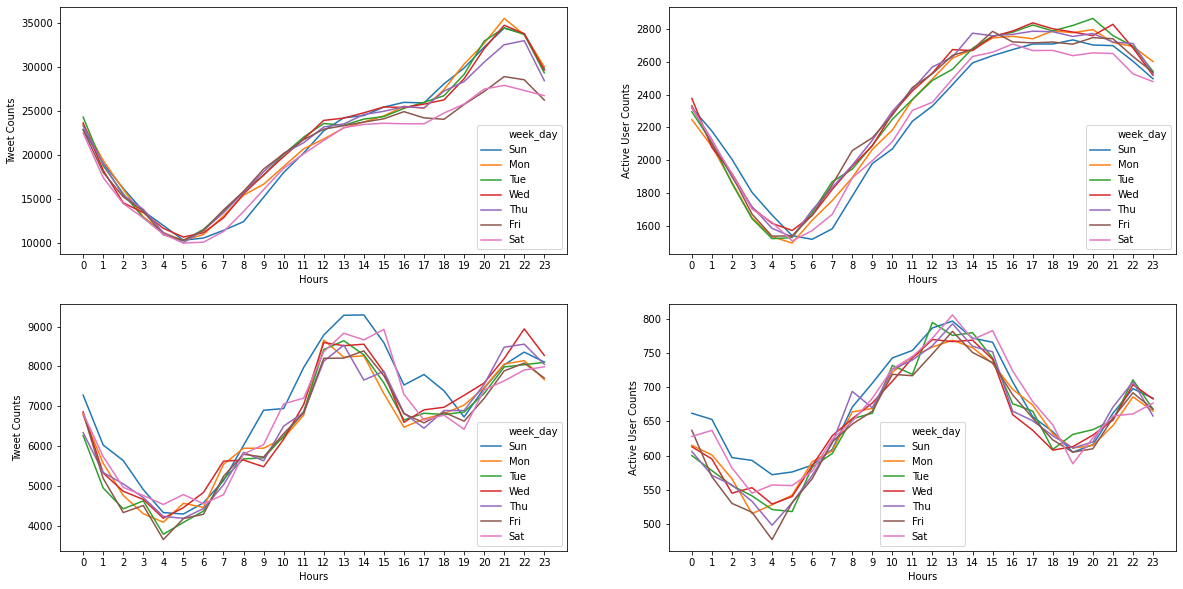

In [36]:
fig, ax = plt.subplots(2, 2, figsize = (20, 10))

sns.lineplot(data = tweet_time_west, x = 'hour', y = 'count', hue = 'week_day', ax = ax[0,0],
             hue_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax[0,0].set_xlabel('Hours')
ax[0,0].set_ylabel('Tweet Counts')
ax[0,0].set_xticks(np.arange(0, 24))

sns.lineplot(data = user_time_west, x = 'hour', y = 'count', hue = 'week_day', ax = ax[0,1],
            hue_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax[0,1].set_xlabel('Hours')
ax[0,1].set_ylabel('Active User Counts')
ax[0,1].set_xticks(np.arange(0, 24))

sns.lineplot(data = tweet_time_east, x = 'hour', y = 'count', hue = 'week_day', ax = ax[1,0],
             hue_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax[1,0].set_xlabel('Hours')
ax[1,0].set_ylabel('Tweet Counts')
ax[1,0].set_xticks(np.arange(0, 24))

sns.lineplot(data = user_time_east, x = 'hour', y = 'count', hue = 'week_day', ax = ax[1,1],
            hue_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax[1,1].set_xlabel('Hours')
ax[1,1].set_ylabel('Active User Counts')
ax[1,1].set_xticks(np.arange(0, 24))

plt.show()

The plot for the eastern and western cultures look quite different. But they still seem to follow the circadian rythm pattern as suggested in the paper. 

But an interesting thing to note is that a peak in the number of tweets is visible around 22h for both west and east, but there is an equally high peak in the number of tweets around 13h in the east. Also, the number of active users gradually increase after 4h for both west and east. But there is a drastic dip in the number of active users between 15h and 21h in the east. The number of tweets is also less during this time in the east (Maybe this is what makes a peak at 13h visible, and there is no reason for peak at 13h but there is a reason for inactivity from 15h to 21h) --What could be the reason for this?

Also, not the difference in scales. 35k vs 9k tweets per day. 2800 vs 800 active users per day. West vs East. 

### Cluster Analysis

In [37]:
ego_network = pd.read_csv("../Data/EgoNetworks.txt", sep = '\t')

In [38]:
ego_alter_list = languages_with_alter['ID'].tolist()

print(len(ego_alter_list))
ego_network = ego_network[(ego_network['followerID'].isin(ego_alter_list)) 
                          & (ego_network['followeeID'].isin(ego_alter_list))]
ego_network.head()

18537


Empty DataFrame
Columns: [egoID, followerID, followeeID]
Index: []

In [39]:
mapping_id_language = dict(zip(languages_with_alter['ID'], languages_with_alter['lang']))

def assign_lang(id):
    return mapping_id_language[id]

ego_network['lang1'] = ego_network['followerID'].apply(assign_lang)
ego_network['lang2'] = ego_network['followeeID'].apply(assign_lang)
ego_network['same_lang'] = np.where(ego_network['lang1'] == ego_network['lang2'], True, False)
ego_network['same_lang'].value_counts()

Series([], Name: same_lang, dtype: int64)

In [40]:
language_order = languages_stat.index.tolist()
mapping_language = dict(zip(language_order, [i for i in range(0, 15)]))

rows, cols = (15, 15) 
connection = [[0 for i in range(cols)] for j in range(rows)] 
follow_pair = list(zip(ego_network['lang1'], ego_network['lang2']))

for i, v in enumerate(follow_pair):
    if follow_pair[i][0] in language_order and follow_pair[i][1] in language_order:
        connection[mapping_language[follow_pair[i][0]]][mapping_language[follow_pair[i][1]]] += 1

connection_dataframe = pd.DataFrame(connection, columns = language_order, index = language_order)  
connection_dataframe.head(15)

ValueError: 14 columns passed, passed data had 15 columns

In [ ]:
fig, ax = plt.subplots(15, 1, figsize = (20, 75), dpi = 300)

for i in range(15):
    ax[i].set(yscale = 'log')
    sns.barplot(x = languages_stat.index, y = connection[i], ax = ax[i])

plt.show()

# Add internationality

In [41]:
# Load the ego networks as DataFrame
ego_networks = pd.read_csv("Data/EgoNetworks.txt", sep = '\t')

newlanguages = pd.read_csv("Data/EgoAlterProfiles.txt", sep = '\t')[['ID','lang']]
newlanguages['lang'] = newlanguages['lang'].str.lower()

# Ignore SettingWithCopyWarning - reference: https://www.dataquest.io/blog/settingwithcopywarning/
pd.set_option('mode.chained_assignment', None)

# Create dictionary mapping between users and their languages 
user_lang = dict(zip(newlanguages['ID'], newlanguages['lang']))

# Function to return user language from ID
def get_lang(ID):
    return user_lang[ID]

# consider only the Ego (as followee)
ego_networks = ego_networks[ ego_networks['followeeID'].isin(languages['ID']) ]

# compute the followee language
ego_networks = pd.merge(ego_networks, languages[['ID','lang']], left_on='followeeID', right_on='ID')
print(ego_networks)
# computw the followers language
ego_networks['followers_lang'] = ego_networks['followerID'].apply(get_lang)

ego_networks = ego_networks.groupby(['egoID','lang','followers_lang']).size().to_frame('size')
ego_networks.reset_index(level=['egoID','lang','followers_lang'], inplace=True)
print(ego_networks)
print(ego_networks[ ego_networks['lang']==ego_networks['followers_lang'] ].groupby(['egoID'])['size'].sum())
print(ego_networks.groupby(['egoID'])['size'].sum())
languages['internationality'] = 0
users = ego_networks[ ego_networks['lang']==ego_networks['followers_lang'] ]['egoID']
print(users)
print(languages['ID'].isin(users))
languages['internationality'][ languages['ID'].isin(users-1) ] = 1 - (ego_networks[ ego_networks['lang']==ego_networks['followers_lang'] ].groupby(['egoID'])['size'].sum() / ego_networks.groupby(['egoID'])['size'].sum())
#print(ego_networks)
#languages = pd.merge(languages, ego_networks[['egoID', 'internationality']], left_on='ID', right_on='egoID')
languages

FileNotFoundError: [Errno 2] File Data/EgoNetworks.txt does not exist: 'Data/EgoNetworks.txt'

In [42]:
languages

ID  IsEgo  followers_count  friends_count  statuses_count lang  \
0          1   True             30.0             28             9.0   en   
1          2   True              2.0              8             7.0   en   
2          4   True              3.0              3            68.0   en   
3          5   True             65.0            118           748.0   fr   
4          7   True             17.0             71          1034.0   pt   
...      ...    ...              ...            ...             ...  ...   
18532  33994   True              1.0             13             0.0   es   
18533  33997   True              1.0              6             0.0   en   
18534  33998   True              1.0             60             1.0   en   
18535  34003   True            194.0             95           370.0   es   
18536  34005   True              1.0             19             0.0   pt   

       area  avg_daily_tweets  
0      West          0.008174  
1      West          0.003644  
2      West          0.039558  
3      West          0.858783  
4      West          0.713596  
...     ...               ...  
18532  West          0.000000  
18533  West          0.000000  
18534  West          0.007246  
18535  West          1.887755  
18536  West          0.000000  

[18537 rows x 8 columns]

# Usupervised Learning

I would like to get the same cluster of the culture

In [43]:
# Load the ego networks as DataFrame
ego_networks = pd.read_csv("Data/EgoNetworks.txt", sep = '\t')

print(ego_networks)

# Filter out rows with egoID, followerID and followeeID which do not have language information
ego_networks_lang = ego_networks[(ego_networks['egoID'].isin(languages['ID'])) & 
                                (ego_networks['followerID'].isin(languages['ID'])) & 
                                (ego_networks['followeeID'].isin(languages['ID']))]

# Ignore SettingWithCopyWarning - reference: https://www.dataquest.io/blog/settingwithcopywarning/
pd.set_option('mode.chained_assignment', None)

# Create dictionary mapping between users and their languages 
user_lang = dict(zip(languages['ID'], languages['lang']))

# Function to return user language from ID
def get_lang(ID):
    return user_lang[ID]

# Add new column with user languages for followers
ego_networks_lang['follower_lang'] = ego_networks_lang['followerID'].apply(get_lang)
# Add new column with user languages for followees
ego_networks_lang['followee_lang'] = ego_networks_lang['followeeID'].apply(get_lang)

# List of languages
lang_names = ['cs', 'fi', 'sv', 'pl', 'da', 'ru', 'fr', 'ca', 'nl', 'de', 'pt', 'it', 'es', 'en-gb', 'en', 
              'ar', 'id', 'tr', 'zh-tw', 'zh-cn', 'ja', 'th', 'ko', 'fil', 'msa']

# Add new columns for each language for followees
for lang_code in lang_names:
    ego_networks_lang[lang_code] = ego_networks_lang['followee_lang'].apply(lambda x: 1 if x == lang_code else 0)

    
    # Drop the irrelevant columns
ego_networks_lang = ego_networks_lang.drop(columns = ['followerID', 'followeeID', 'follower_lang', 'followee_lang'])
ego_networks_lang.head()

# Create new df, Group by egoID to give the final df
ml_dataset = ego_networks_lang.groupby(['egoID']).sum()
ml_dataset

FileNotFoundError: [Errno 2] File Data/EgoNetworks.txt does not exist: 'Data/EgoNetworks.txt'

In [44]:
# Load the ego networks as DataFrame
ego_networks = pd.read_csv("Data/EgoNetworks.txt", sep = '\t')
ego_networks

FileNotFoundError: [Errno 2] File Data/EgoNetworks.txt does not exist: 'Data/EgoNetworks.txt'

In [45]:
# Method needs the languages df
languages

ID  IsEgo  followers_count  friends_count  statuses_count lang  \
0          1   True             30.0             28             9.0   en   
1          2   True              2.0              8             7.0   en   
2          4   True              3.0              3            68.0   en   
3          5   True             65.0            118           748.0   fr   
4          7   True             17.0             71          1034.0   pt   
...      ...    ...              ...            ...             ...  ...   
18532  33994   True              1.0             13             0.0   es   
18533  33997   True              1.0              6             0.0   en   
18534  33998   True              1.0             60             1.0   en   
18535  34003   True            194.0             95           370.0   es   
18536  34005   True              1.0             19             0.0   pt   

       area  avg_daily_tweets  
0      West          0.008174  
1      West          0.003644  
2      West          0.039558  
3      West          0.858783  
4      West          0.713596  
...     ...               ...  
18532  West          0.000000  
18533  West          0.000000  
18534  West          0.007246  
18535  West          1.887755  
18536  West          0.000000  

[18537 rows x 8 columns]

In [46]:
# Filter out rows with egoID, followerID and followeeID which do not have language information
ego_networks_lang = ego_networks[(ego_networks['egoID'].isin(languages['ID'])) & 
                                (ego_networks['followerID'].isin(languages['ID'])) & 
                                (ego_networks['followeeID'].isin(languages['ID']))]

NameError: name 'ego_networks' is not defined

In [47]:
print("Original ego_networks df had %d rows, but the new ego_networks_lang df has %d rows" 
      %(ego_networks.shape[0], ego_networks_lang.shape[0]))

NameError: name 'ego_networks' is not defined

In [48]:
# Ignore SettingWithCopyWarning - reference: https://www.dataquest.io/blog/settingwithcopywarning/
pd.set_option('mode.chained_assignment', None)

In [49]:
# Create dictionary mapping between users and their languages 
user_lang = dict(zip(languages['ID'], languages['lang']))

# Function to return user language from ID
def get_lang(ID):
    return user_lang[ID]

# Add new column with user languages for followers
ego_networks_lang['follower_lang'] = ego_networks_lang['followerID'].apply(get_lang)
# Add new column with user languages for followees
ego_networks_lang['followee_lang'] = ego_networks_lang['followeeID'].apply(get_lang)

NameError: name 'ego_networks_lang' is not defined

In [50]:
ego_networks_lang.head()

NameError: name 'ego_networks_lang' is not defined

In [51]:
# List of languages
lang_names = ['cs', 'fi', 'sv', 'pl', 'da', 'ru', 'fr', 'ca', 'nl', 'de', 'pt', 'it', 'es', 'en-gb', 'en', 
              'ar', 'id', 'tr', 'zh-tw', 'zh-cn', 'ja', 'th', 'ko', 'fil', 'msa']

In [52]:
# Add new columns for each language for followers
#for lang_code in lang_names:
    #ego_networks_lang['follower_lang_' + lang_code] = ego_networks_lang['follower_lang'].apply(lambda x: 1 if x == lang_code else 0)

# Add new columns for each language for followees
for lang_code in lang_names:
    ego_networks_lang['followee_lang_' + lang_code] = ego_networks_lang['followee_lang'].apply(lambda x: 1 if x == lang_code else 0)

NameError: name 'ego_networks_lang' is not defined

In [53]:
ego_networks_lang.head()

NameError: name 'ego_networks_lang' is not defined

In [54]:
# Drop the irrelevant columns
ego_networks_lang = ego_networks_lang.drop(columns = ['followerID', 'followeeID', 'follower_lang', 'followee_lang'])
ego_networks_lang.head()

NameError: name 'ego_networks_lang' is not defined

In [55]:
# Create new df, Group by egoID to give the final df
ml_dataset = ego_networks_lang.groupby(['egoID']).sum()

NameError: name 'ego_networks_lang' is not defined

In [56]:
ml_dataset = ml_dataset.div(ml_dataset.sum(axis=1), axis=0)

users = list(ml_dataset.index)

NameError: name 'ml_dataset' is not defined

In [57]:
from sklearn.preprocessing import StandardScaler

ml_dataset = StandardScaler().fit(ml_dataset).transform(ml_dataset)

NameError: name 'ml_dataset' is not defined

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

X_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(ml_dataset)
#X_reduced_pca = PCA(n_components=2).fit(ml_dataset).transform(ml_dataset)

In [ ]:
dict_lang = dict( zip(list(set(languages[ languages['ID'].isin(users) ]['lang'])), list(range(25)) ))
def color_lang(x):
    return dict_lang[x]

In [ ]:
labels_lang = languages[ languages['ID'].isin(users) ]['lang'].apply(lambda x: color_lang(x))
labels_area = languages[ languages['ID'].isin(users) ]['area'].apply(lambda x: 1 if x=='West' else 0)

predicted = KMeans(n_clusters=2, random_state=0).fit_predict(ml_dataset)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

Axes3D.plot(X_reduced_tsne[:,0], X_reduced_tsne[:,1], X_reduced_tsne[:,2], c=labels_area)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

Axes3D.plot(X_reduced_tsne[:,0], X_reduced_tsne[:,1], X_reduced_tsne[:,2], c=predicted)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)

axs[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels_area, alpha=0.6)
axs[0].set_title("Original Types (TSNE)")

axs[1].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=predicted, alpha=0.6)
axs[1].set_title("Discovered clusters (TSNE)")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)

axs[0].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=labels_lang, alpha=0.6)
axs[0].set_title("Original Types (PCA)")

axs[1].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=predicted, alpha=0.6)
axs[1].set_title("Discovered clusters (PCA)")

In [ ]:
# List of egoIDs in the dataset
ml_egoIDs = ml_dataset.index.tolist()
print(len(ml_egoIDs))

In [ ]:
ml_dataset.to_csv(r'ml_dataset_1.csv', index = False)